In [1]:
import numpy as np
import pandas as pd
import mne
from mne.channels import make_standard_montage
import numpy as np
import copy
import matplotlib.pyplot as plt
import mne
from autoreject import get_rejection_threshold, AutoReject
from mne.preprocessing import ICA, corrmap
from numpy import genfromtxt
import seaborn as sns
import statsmodels
print(statsmodels.__version__)
import scipy
from scipy import stats
from hypyp import analyses
from hypyp import viz
import math
import itertools
import random
import plotly.graph_objects as go
#my_data = genfromtxt('Hyper39_Dual3.txt', delimiter=',',dtype=None)

0.13.5


In [2]:
print(pd.__version__)

2.0.0


In [3]:
class Df_metka():
    def __init__(self,name,path):
        self.name = name
        self.df = pd.read_csv(path, sep=",",header=None)
        self.df_path = path.replace('_Metki', '')
        self.metki = self.df.drop(self.df.iloc[:, 2:(len(self.df.columns))],axis=1)
        self.metki_del = np.where((self.metki[1]==0)|(self.metki[1]==9))[0]
        self.metki.drop(index=self.metki_del,inplace=True)
        self.metki.insert(1, 2, [0 for i in range(self.metki.shape[0])])
        self.metki[0] = ((self.metki[0]/1000)*500).apply(math.floor)
        self.frame = pd.read_csv(self.df_path , sep='\s+',header=None)
        Q1 = self.frame.quantile(0.25)
        Q3 = self.frame.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 5*IQR
        upper = Q3 + 5*IQR
#         self.condit = np.where((self.frame>=upper)|(self.frame<=lower))[0] 
#         self.frame.drop(index=self.condit,inplace=True)
        self.frame = self.frame.T

In [4]:
df_3_4 = Df_metka('3_4','Metki/Hyper03_Hyper04_Metki.txt')
df_15_16 = Df_metka('15_16','Metki/Hyper15_Hyper16_Metki.txt')

In [5]:
df_21_22 = Df_metka('21_22','Metki/Hyper21-Hyper22_Metki.txt')
df_27_28 = Df_metka('27_28','Metki/Hyper27-Hyper28_Metki.txt')
df_29_30 = Df_metka('29_30','Metki/Hyper29-Hyper30_Metki.txt')
df_31_32 = Df_metka('31_32','Metki/Hyper31-Hyper32_Metki.txt')
df_33_34 = Df_metka('33_34','Metki/Hyper33-Hyper34_Metki.txt')
df_35_36 = Df_metka('35_36','Metki/Hyper35-Hyper36_Metki.txt')
df_41_42 = Df_metka('41_42','Metki/Hyper41-Hyper42_Metki.txt')
df_43_44 = Df_metka('43_44','Metki/Hyper43-Hyper44_Metki.txt')

In [6]:
def connectivity(df_num):
    metki_num = df_num.metki
    dataframe_num = df_num.frame
    sfreq = 500  # Hz
    sampling_rate = sfreq
    ch_names = ['Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3',
                'C4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
    info = mne.create_info(ch_names, sfreq, ch_types='eeg')
    mne_array_1 = mne.io.RawArray(dataframe_num.iloc[0:15], info)
    mne_array_2 = mne.io.RawArray(dataframe_num.iloc[15:], info)
    event_id = {'First': 1, 'Second': 2}
    events_mne = metki_num.to_numpy()
    # montage = mne.channels.make_standard_montage('biosemi16')
    locations = {'Fpz': [0, 0.08, 0], 'F7': [-0.06, 0.04, 0], 'F3': [-0.03, 0.04, 0], 'Fz': [0, 0.04, 0], 'F4': [0.03, 0.04, 0],
                 'F8': [0.06, 0.04, 0], 'C3': [-0.03, 0, 0], 'C4': [0.03, 0, 0], 'T5': [-0.06, -0.04, 0], 'P3': [-0.03, -0.04, 0],
                 'Pz': [0, -0.04, 0], 'P4': [0.03, -0.04, 0], 'T6': [0.06, -0.04, 0], 'O1': [-0.02, -0.08, 0], 'O2': [0.02, -0.08, 0]}
    montage = mne.channels.make_dig_montage(locations)
    mne_array_1.set_montage(montage)
    mne_array_2.set_montage(montage)
    interval_min_sec = metki_num[0].diff().min()/500
    epoch_1 = mne.Epochs(mne_array_1, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    epoch_2 = mne.Epochs(mne_array_2, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    cleaned_epochs_no_ICA = [epoch_1, epoch_2]
    # without ICA
    print(cleaned_epochs_no_ICA)
#     no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
#                                           strategy="union",
#                                           threshold=50.0,
#                                           verbose=True
#     )
    no_ICA_preproc_S1 = cleaned_epochs_no_ICA[0]  # no_ICA_cleaned_epochs_AR[0]
    no_ICA_preproc_S2 = cleaned_epochs_no_ICA[1]  # no_ICA_cleaned_epochs_AR[1]
    data_inter_no_ICA_1 = np.array(
        [no_ICA_preproc_S1['First'], no_ICA_preproc_S2['First']])
    data_inter_no_ICA_2 = np.array(
        [no_ICA_preproc_S1['Second'], no_ICA_preproc_S2['Second']])
    no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])
    freq_bands = {'alpha': [7.5, 11.5], 'beta': [12, 20]}
    # complex_signal = analyses.compute_freq_bands(data_inter_1,sampling_rate, freq_bands=freq_bands)
    # without ICA
    no_ICA_complex_signal_1 = analyses.compute_freq_bands(
        data_inter_no_ICA_1, sampling_rate, freq_bands)
    no_ICA_complex_signal_2 = analyses.compute_freq_bands(
        data_inter_no_ICA_2, sampling_rate, freq_bands)
    result_1 = analyses.compute_sync(no_ICA_complex_signal_1, mode='ccorr')
    result_2 = analyses.compute_sync(no_ICA_complex_signal_2, mode='ccorr')
    n_ch = len(epoch_1.info['ch_names'])
    alpha_1, betta_1 = result_1[:, 0:n_ch, n_ch:2*n_ch]
    alpha_2, betta_2 = result_2[:, 0:n_ch, n_ch:2*n_ch]
    return alpha_1, alpha_2

In [7]:
def permutation(df_num):
    metki_num = df_num.metki
    dataframe_num = df_num.frame
    sfreq = 500  # Hz
    sampling_rate = sfreq
    ch_names = ['Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3',
                'C4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
    info = mne.create_info(ch_names, sfreq, ch_types='eeg')
    mne_array_1 = mne.io.RawArray(dataframe_num.iloc[0:15], info)
    mne_array_2 = mne.io.RawArray(dataframe_num.iloc[15:], info)
    event_id = {'First': 1, 'Second': 2}
    events_mne = metki_num.to_numpy()
    # montage = mne.channels.make_standard_montage('biosemi16')
    locations = {'Fpz': [0, 0.08, 0], 'F7': [-0.06, 0.04, 0], 'F3': [-0.03, 0.04, 0], 'Fz': [0, 0.04, 0], 'F4': [0.03, 0.04, 0],
                 'F8': [0.06, 0.04, 0], 'C3': [-0.03, 0, 0], 'C4': [0.03, 0, 0], 'T5': [-0.06, -0.04, 0], 'P3': [-0.03, -0.04, 0],
                 'Pz': [0, -0.04, 0], 'P4': [0.03, -0.04, 0], 'T6': [0.06, -0.04, 0], 'O1': [-0.02, -0.08, 0], 'O2': [0.02, -0.08, 0]}
    montage = mne.channels.make_dig_montage(locations)
    mne_array_1.set_montage(montage)
    mne_array_2.set_montage(montage)
    interval_min_sec = metki_num[0].diff().min()/500
    epoch_1 = mne.Epochs(mne_array_1, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    epoch_2 = mne.Epochs(mne_array_2, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    rng = np.random.default_rng(random.randint(0,42))
    perm_1, perm_2 = rng.permutation(len(epoch_1)), rng.permutation(len(epoch_2))
    epoch_1_permutted = epoch_1[perm_1]
    epoch_2_permutted = epoch_2[perm_2]
    cleaned_epochs_no_ICA = [epoch_1_permutted, epoch_2_permutted]
#     no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
#                                           strategy="union",
#                                           threshold=50.0,
#                                           verbose=True
#     )
    no_ICA_preproc_S1 = cleaned_epochs_no_ICA[0]  # no_ICA_cleaned_epochs_AR[0]
    no_ICA_preproc_S2 = cleaned_epochs_no_ICA[1]  # no_ICA_cleaned_epochs_AR[1]
    data_inter_no_ICA_1 = np.array(
        [no_ICA_preproc_S1['First'], no_ICA_preproc_S2['First']])
    data_inter_no_ICA_2 = np.array(
        [no_ICA_preproc_S1['Second'], no_ICA_preproc_S2['Second']])
    no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])
    freq_bands = {'alpha': [7.5, 11.5], 'beta': [12, 20]}
    # complex_signal = analyses.compute_freq_bands(data_inter_1,sampling_rate, freq_bands=freq_bands)
    # without ICA
    no_ICA_complex_signal_1 = analyses.compute_freq_bands(
        data_inter_no_ICA_1, sampling_rate, freq_bands)
    no_ICA_complex_signal_2 = analyses.compute_freq_bands(
        data_inter_no_ICA_2, sampling_rate, freq_bands)
    result_1 = analyses.compute_sync(no_ICA_complex_signal_1, mode='ccorr')
    result_2 = analyses.compute_sync(no_ICA_complex_signal_2, mode='ccorr')
    n_ch = len(epoch_1.info['ch_names'])
    alpha_1, betta_1 = result_1[:, 0:n_ch, n_ch:2*n_ch]
    alpha_2, betta_2 = result_2[:, 0:n_ch, n_ch:2*n_ch]
    return alpha_1, alpha_2

In [8]:
def time_permutation(df_num):
    metki_num = df_num.metki
    dataframe_num = df_num.frame
    dataframe_num = dataframe_num.reindex((np.random.permutation(dataframe_num.columns)), axis=1)
    sfreq = 500  # Hz
    sampling_rate = sfreq
    ch_names = ['Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3',
                'C4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
    info = mne.create_info(ch_names, sfreq, ch_types='eeg')
    mne_array_1 = mne.io.RawArray(dataframe_num.iloc[0:15], info)
    mne_array_2 = mne.io.RawArray(dataframe_num.iloc[15:], info)
    event_id = {'First': 1, 'Second': 2}
    events_mne = metki_num.to_numpy()
    # montage = mne.channels.make_standard_montage('biosemi16')
    locations = {'Fpz': [0, 0.08, 0], 'F7': [-0.06, 0.04, 0], 'F3': [-0.03, 0.04, 0], 'Fz': [0, 0.04, 0], 'F4': [0.03, 0.04, 0],
                 'F8': [0.06, 0.04, 0], 'C3': [-0.03, 0, 0], 'C4': [0.03, 0, 0], 'T5': [-0.06, -0.04, 0], 'P3': [-0.03, -0.04, 0],
                 'Pz': [0, -0.04, 0], 'P4': [0.03, -0.04, 0], 'T6': [0.06, -0.04, 0], 'O1': [-0.02, -0.08, 0], 'O2': [0.02, -0.08, 0]}
    montage = mne.channels.make_dig_montage(locations)
    mne_array_1.set_montage(montage)
    mne_array_2.set_montage(montage)
    interval_min_sec = metki_num[0].diff().min()/500
    epoch_1 = mne.Epochs(mne_array_1, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    epoch_2 = mne.Epochs(mne_array_2, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    cleaned_epochs_no_ICA = [epoch_1, epoch_2]
    # without ICA
    print(cleaned_epochs_no_ICA)
#     no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
#                                           strategy="union",
#                                           threshold=50.0,
#                                           verbose=True
#     )
    no_ICA_preproc_S1 = cleaned_epochs_no_ICA[0]  # no_ICA_cleaned_epochs_AR[0]
    no_ICA_preproc_S2 = cleaned_epochs_no_ICA[1]  # no_ICA_cleaned_epochs_AR[1]
    data_inter_no_ICA_1 = np.array(
        [no_ICA_preproc_S1['First'], no_ICA_preproc_S2['First']])
    data_inter_no_ICA_2 = np.array(
        [no_ICA_preproc_S1['Second'], no_ICA_preproc_S2['Second']])
    no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])
    freq_bands = {'alpha': [7.5, 11.5], 'beta': [12, 20]}
    # complex_signal = analyses.compute_freq_bands(data_inter_1,sampling_rate, freq_bands=freq_bands)
    # without ICA
    no_ICA_complex_signal_1 = analyses.compute_freq_bands(
        data_inter_no_ICA_1, sampling_rate, freq_bands)
    no_ICA_complex_signal_2 = analyses.compute_freq_bands(
        data_inter_no_ICA_2, sampling_rate, freq_bands)
    result_1 = analyses.compute_sync(no_ICA_complex_signal_1, mode='ccorr')
    result_2 = analyses.compute_sync(no_ICA_complex_signal_2, mode='ccorr')
    n_ch = len(epoch_1.info['ch_names'])
    alpha_1, betta_1 = result_1[:, 0:n_ch, n_ch:2*n_ch]
    alpha_2, betta_2 = result_2[:, 0:n_ch, n_ch:2*n_ch]
    return alpha_1, alpha_2

In [9]:
def alpha_distr_time(df_num):
    metki_num = df_num.metki
    dataframe_num = df_num.frame
    dataframe_num = dataframe_num.reindex((np.random.permutation(dataframe_num.columns)), axis=1)
    sfreq = 500  # Hz
    sampling_rate = sfreq
    ch_names = ['Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3',
                'C4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
    info = mne.create_info(ch_names, sfreq, ch_types='eeg')
    mne_array_1 = mne.io.RawArray(dataframe_num.iloc[0:15], info)
    mne_array_2 = mne.io.RawArray(dataframe_num.iloc[15:], info)
    event_id = {'First': 1, 'Second': 2}
    events_mne = metki_num.to_numpy()
    # montage = mne.channels.make_standard_montage('biosemi16')
    locations = {'Fpz': [0, 0.08, 0], 'F7': [-0.06, 0.04, 0], 'F3': [-0.03, 0.04, 0], 'Fz': [0, 0.04, 0], 'F4': [0.03, 0.04, 0],
                 'F8': [0.06, 0.04, 0], 'C3': [-0.03, 0, 0], 'C4': [0.03, 0, 0], 'T5': [-0.06, -0.04, 0], 'P3': [-0.03, -0.04, 0],
                 'Pz': [0, -0.04, 0], 'P4': [0.03, -0.04, 0], 'T6': [0.06, -0.04, 0], 'O1': [-0.02, -0.08, 0], 'O2': [0.02, -0.08, 0]}
    montage = mne.channels.make_dig_montage(locations)
    mne_array_1.set_montage(montage)
    mne_array_2.set_montage(montage)
    interval_min_sec = metki_num[0].diff().min()/500
    epoch_1 = mne.Epochs(mne_array_1, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    epoch_2 = mne.Epochs(mne_array_2, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    cleaned_epochs_no_ICA = [epoch_1, epoch_2]
    # without ICA
    print(cleaned_epochs_no_ICA)
#     no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
#                                           strategy="union",
#                                           threshold=50.0,
#                                           verbose=True
#     )
    no_ICA_preproc_S1 = cleaned_epochs_no_ICA[0]  # no_ICA_cleaned_epochs_AR[0]
    no_ICA_preproc_S2 = cleaned_epochs_no_ICA[1]  # no_ICA_cleaned_epochs_AR[1]
    data_inter_no_ICA_1 = np.array(
        [no_ICA_preproc_S1['First'], no_ICA_preproc_S2['First']])
    data_inter_no_ICA_2 = np.array(
        [no_ICA_preproc_S1['Second'], no_ICA_preproc_S2['Second']])
    no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])
    freq_bands = {'alpha': [7.5, 11.5], 'beta': [12, 20]}
    # complex_signal = analyses.compute_freq_bands(data_inter_1,sampling_rate, freq_bands=freq_bands)
    # without ICA
    no_ICA_complex_signal_1 = analyses.compute_freq_bands(
        data_inter_no_ICA_1, sampling_rate, freq_bands)
    no_ICA_complex_signal_2 = analyses.compute_freq_bands(
        data_inter_no_ICA_2, sampling_rate, freq_bands)
    result_1 = analyses.compute_sync(no_ICA_complex_signal_1, mode='ccorr',epochs_average=False)
    result_2 = analyses.compute_sync(no_ICA_complex_signal_2, mode='ccorr',epochs_average=False)
    n_ch = len(epoch_1.info['ch_names'])
    alpha_1_dist, betta_1_dist = result_1[:, 0:n_ch, n_ch:2*n_ch]
    alpha_2_dist, betta_2_dist = result_2[:, 0:n_ch, n_ch:2*n_ch]
    return alpha_1_dist, alpha_2_dist

In [10]:
def alpha_distr_Testing(df_num):
    metki_num = df_num.metki
    dataframe_num = df_num.frame
    dataframe_num = dataframe_num.reindex((np.random.permutation(dataframe_num.columns)), axis=1)
    sfreq = 500  # Hz
    sampling_rate = sfreq
    ch_names = ['Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3',
                'C4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
    info = mne.create_info(ch_names, sfreq, ch_types='eeg')
    mne_array_1 = mne.io.RawArray(dataframe_num.iloc[0:15], info)
    mne_array_2 = mne.io.RawArray(dataframe_num.iloc[15:], info)
    event_id = {'First': 1, 'Second': 2}
    events_mne = metki_num.to_numpy()
    # montage = mne.channels.make_standard_montage('biosemi16')
    locations = {'Fpz': [0, 0.08, 0], 'F7': [-0.06, 0.04, 0], 'F3': [-0.03, 0.04, 0], 'Fz': [0, 0.04, 0], 'F4': [0.03, 0.04, 0],
                 'F8': [0.06, 0.04, 0], 'C3': [-0.03, 0, 0], 'C4': [0.03, 0, 0], 'T5': [-0.06, -0.04, 0], 'P3': [-0.03, -0.04, 0],
                 'Pz': [0, -0.04, 0], 'P4': [0.03, -0.04, 0], 'T6': [0.06, -0.04, 0], 'O1': [-0.02, -0.08, 0], 'O2': [0.02, -0.08, 0]}
    montage = mne.channels.make_dig_montage(locations)
    mne_array_1.set_montage(montage)
    mne_array_2.set_montage(montage)
    interval_min_sec = metki_num[0].diff().min()/500
    epoch_1 = mne.Epochs(mne_array_1, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    epoch_2 = mne.Epochs(mne_array_2, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    cleaned_epochs_no_ICA = [epoch_1, epoch_2]
    # without ICA
    print(cleaned_epochs_no_ICA)
#     no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
#                                           strategy="union",
#                                           threshold=50.0,
#                                           verbose=True
#     )
    no_ICA_preproc_S1 = cleaned_epochs_no_ICA[0]  # no_ICA_cleaned_epochs_AR[0]
    no_ICA_preproc_S2 = cleaned_epochs_no_ICA[1]  # no_ICA_cleaned_epochs_AR[1]
    data_inter_no_ICA_1 = np.array(
        [no_ICA_preproc_S1['First'], no_ICA_preproc_S2['First']])
    data_inter_no_ICA_2 = np.array(
        [no_ICA_preproc_S1['Second'], no_ICA_preproc_S2['Second']])
    no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])
    freq_bands = {'alpha': [7.5, 11.5], 'beta': [12, 20]}
    # complex_signal = analyses.compute_freq_bands(data_inter_1,sampling_rate, freq_bands=freq_bands)
    # without ICA
    no_ICA_complex_signal_1 = analyses.compute_freq_bands(
        data_inter_no_ICA_1, sampling_rate, freq_bands)
    no_ICA_complex_signal_2 = analyses.compute_freq_bands(
        data_inter_no_ICA_2, sampling_rate, freq_bands)
    result_1 = analyses.compute_sync(no_ICA_complex_signal_1, mode='ccorr',epochs_average=False)
    result_2 = analyses.compute_sync(no_ICA_complex_signal_2, mode='ccorr',epochs_average=False)
    n_ch = len(epoch_1.info['ch_names'])
    alpha_1_dist, betta_1_dist = result_1[:, 0:n_ch, n_ch:2*n_ch]
    alpha_2_dist, betta_2_dist = result_2[:, 0:n_ch, n_ch:2*n_ch]
    return result_1

In [106]:
# TESTING = alpha_distr_Testing(df_15_16)

In [104]:
TESTING.shape

(2, 71, 30, 30)

In [11]:
def get_epochs(df_num):
    metki_num = df_num.metki
    dataframe_num = df_num.frame
    sfreq = 500  # Hz
    sampling_rate = sfreq
    ch_names = ['Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'C3',
                'C4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
    info = mne.create_info(ch_names, sfreq, ch_types='eeg')
    mne_array_1 = mne.io.RawArray(dataframe_num.iloc[0:15], info)
    mne_array_2 = mne.io.RawArray(dataframe_num.iloc[15:], info)
    event_id = {'First': 1, 'Second': 2}
    events_mne = metki_num.to_numpy()
    # montage = mne.channels.make_standard_montage('biosemi16')
    locations = {'Fpz': [0, 0.08, 0], 'F7': [-0.06, 0.04, 0], 'F3': [-0.03, 0.04, 0], 'Fz': [0, 0.04, 0], 'F4': [0.03, 0.04, 0],
                 'F8': [0.06, 0.04, 0], 'C3': [-0.03, 0, 0], 'C4': [0.03, 0, 0], 'T5': [-0.06, -0.04, 0], 'P3': [-0.03, -0.04, 0],
                 'Pz': [0, -0.04, 0], 'P4': [0.03, -0.04, 0], 'T6': [0.06, -0.04, 0], 'O1': [-0.02, -0.08, 0], 'O2': [0.02, -0.08, 0]}
    montage = mne.channels.make_dig_montage(locations)
    mne_array_1.set_montage(montage)
    mne_array_2.set_montage(montage)
    interval_min_sec = metki_num[0].diff().min()/500
    epoch_1 = mne.Epochs(mne_array_1, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
    epoch_2 = mne.Epochs(mne_array_2, events_mne, event_id, preload=True,tmin=0,tmax=interval_min_sec,baseline=None)
#     cleaned_epochs_no_ICA = [epoch_1_permutted, epoch_2_permutted]
#     no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
#                                           strategy="union",
#                                           threshold=50.0,
#                                           verbose=True
#     )
#     no_ICA_preproc_S1 = cleaned_epochs_no_ICA[0]  # no_ICA_cleaned_epochs_AR[0]
#     no_ICA_preproc_S2 = cleaned_epochs_no_ICA[1]  # no_ICA_cleaned_epochs_AR[1]
#     data_inter_no_ICA_1 = np.array(
#         [no_ICA_preproc_S1['First'], no_ICA_preproc_S2['First']])
#     data_inter_no_ICA_2 = np.array(
#         [no_ICA_preproc_S1['Second'], no_ICA_preproc_S2['Second']])
#     no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])
#     freq_bands = {'alpha': [7.5, 11.5], 'beta': [12, 20]}
#     # complex_signal = analyses.compute_freq_bands(data_inter_1,sampling_rate, freq_bands=freq_bands)
#     # without ICA
#     no_ICA_complex_signal_1 = analyses.compute_freq_bands(
#         data_inter_no_ICA_1, sampling_rate, freq_bands)
#     no_ICA_complex_signal_2 = analyses.compute_freq_bands(
#         data_inter_no_ICA_2, sampling_rate, freq_bands)
#     result_1 = analyses.compute_sync(no_ICA_complex_signal_1, mode='ccorr')
#     result_2 = analyses.compute_sync(no_ICA_complex_signal_2, mode='ccorr')
#     n_ch = len(epoch_1.info['ch_names'])
#     alpha_1, betta_1 = result_1[:, 0:n_ch, n_ch:2*n_ch]
#     alpha_2, betta_2 = result_2[:, 0:n_ch, n_ch:2*n_ch]
    return epoch_1,epoch_2

In [105]:
# alpha_3_4_1_dist,alpha_3_4_2_dist = alpha_distr_time(df_3_4)
# alpha_15_16_1_dist,alpha_15_16_2_dist = alpha_distr_time(df_15_16)
# alpha_21_22_1_dist,alpha_21_22_2_dist = alpha_distr_time(df_21_22)
# alpha_27_28_1_dist,alpha_27_28_2_dist = alpha_distr_time(df_27_28)
# alpha_29_30_1_dist,alpha_29_30_2_dist = alpha_distr_time(df_29_30)
# alpha_31_32_1_dist,alpha_31_32_2_dist = alpha_distr_time(df_31_32)
# alpha_33_34_1_dist,alpha_33_34_2_dist = alpha_distr_time(df_33_34)
# alpha_35_36_1_dist,alpha_35_36_2_dist = alpha_distr_time(df_35_36)
# alpha_41_42_1_dist,alpha_41_42_2_dist = alpha_distr_time(df_41_42)
# alpha_43_44_1_dist,alpha_43_44_2_dist = alpha_distr_time(df_43_44)

In [12]:
alpha_3_4_1,alpha_3_4_2 = connectivity(df_3_4)
alpha_15_16_1,alpha_15_16_2 = connectivity(df_15_16)
alpha_21_22_1,alpha_21_22_2 = connectivity(df_21_22)
alpha_27_28_1,alpha_27_28_2 = connectivity(df_27_28)
alpha_29_30_1,alpha_29_30_2 = connectivity(df_29_30)
alpha_31_32_1,alpha_31_32_2 = connectivity(df_31_32)
alpha_33_34_1,alpha_33_34_2 = connectivity(df_33_34)
alpha_35_36_1,alpha_35_36_2 = connectivity(df_35_36)
alpha_41_42_1,alpha_41_42_2 = connectivity(df_41_42)
alpha_43_44_1,alpha_43_44_2 = connectivity(df_43_44)

Creating RawArray with float64 data, n_channels=15, n_times=1244927
    Range : 0 ... 1244926 =      0.000 ...  2489.852 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1244927
    Range : 0 ... 1244926 =      0.000 ...  2489.852 secs
Ready.
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 187 events and 4210 original time points ...
0 bad epochs dropped
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 187 events and 4210 original time points ...
0 bad epochs dropped
[<Epochs |  187 events (all good), 0 – 8.418 s, baseline off, ~90.1 MB, data loaded,
 'First': 77
 'Second': 110>, <Epochs |  187 events (all good), 0 – 8.418 s, baseline off, ~90.1 MB, data loaded,
 'First': 77
 'Second': 110>]


C:\Temp\ipykernel_1456\954498912.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\954498912.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1278070
    Range : 0 ... 1278069 =      0.000 ...  2556.138 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1278070
    Range : 0 ... 1278069 =      0.000 ...  2556.138 secs
Ready.
Not setting metadata
167 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 167 events and 4211 original time points ...
0 bad epochs dropped
Not setting metadata
167 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 167 events and 4211 original time points ...
0 bad epochs dropped
[<Epochs |  167 events (all good), 0 – 8.42 s, baseline off, ~80.5 MB, data loaded,
 'First': 71
 'Second': 96>, <Epochs |  167 events (all good), 0 – 8.42 s, baseline off, ~80.5 MB, data loaded,
 'First': 71
 'Second': 96>]


C:\Temp\ipykernel_1456\954498912.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\954498912.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1538136
    Range : 0 ... 1538135 =      0.000 ...  3076.270 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1538136
    Range : 0 ... 1538135 =      0.000 ...  3076.270 secs
Ready.
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 238 events and 3289 original time points ...
0 bad epochs dropped
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 238 events and 3289 original time points ...
0 bad epochs dropped
[<Epochs |  238 events (all good), 0 – 6.576 s, baseline off, ~89.6 MB, data loaded,
 'First': 110
 'Second': 128>, <Epochs |  238 events (all good), 0 – 6.576 s, baseline off, ~89.6 MB, data loaded,
 'First': 110
 'Second': 128>]


C:\Temp\ipykernel_1456\954498912.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\954498912.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1152112
    Range : 0 ... 1152111 =      0.000 ...  2304.222 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1152112
    Range : 0 ... 1152111 =      0.000 ...  2304.222 secs
Ready.
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 209 events and 3287 original time points ...
0 bad epochs dropped
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 209 events and 3287 original time points ...
0 bad epochs dropped
[<Epochs |  209 events (all good), 0 – 6.572 s, baseline off, ~78.6 MB, data loaded,
 'First': 108
 'Second': 101>, <Epochs |  209 events (all good), 0 – 6.572 s, baseline off, ~78.6 MB, data loaded,
 'First': 108
 'Second': 101>]


C:\Temp\ipykernel_1456\954498912.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\954498912.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1528208
    Range : 0 ... 1528207 =      0.000 ...  3056.414 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1528208
    Range : 0 ... 1528207 =      0.000 ...  3056.414 secs
Ready.
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 4170 original time points ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 4170 original time points ...
0 bad epochs dropped
[<Epochs |  232 events (all good), 0 – 8.338 s, baseline off, ~110.7 MB, data loaded,
 'First': 103
 'Second': 129>, <Epochs |  232 events (all good), 0 – 8.338 s, baseline off, ~110.7 MB, data loaded,
 'First': 103
 'Second': 129>]


C:\Temp\ipykernel_1456\954498912.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\954498912.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527536
    Range : 0 ... 1527535 =      0.000 ...  3055.070 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527536
    Range : 0 ... 1527535 =      0.000 ...  3055.070 secs
Ready.
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 4174 original time points ...
0 bad epochs dropped
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 4174 original time points ...
0 bad epochs dropped
[<Epochs |  216 events (all good), 0 – 8.346 s, baseline off, ~103.2 MB, data loaded,
 'First': 90
 'Second': 126>, <Epochs |  216 events (all good), 0 – 8.346 s, baseline off, ~103.2 MB, data loaded,
 'First': 90
 'Second': 126>]


C:\Temp\ipykernel_1456\954498912.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\954498912.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1525461
    Range : 0 ... 1525460 =      0.000 ...  3050.920 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1525461
    Range : 0 ... 1525460 =      0.000 ...  3050.920 secs
Ready.
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 219 events and 3656 original time points ...
0 bad epochs dropped
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 219 events and 3656 original time points ...
0 bad epochs dropped
[<Epochs |  219 events (all good), 0 – 7.31 s, baseline off, ~91.7 MB, data loaded,
 'First': 93
 'Second': 126>, <Epochs |  219 events (all good), 0 – 7.31 s, baseline off, ~91.7 MB, data loaded,
 'First': 93
 'Second': 126>]


C:\Temp\ipykernel_1456\954498912.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\954498912.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527649
    Range : 0 ... 1527648 =      0.000 ...  3055.296 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527649
    Range : 0 ... 1527648 =      0.000 ...  3055.296 secs
Ready.
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 3655 original time points ...
0 bad epochs dropped
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 3655 original time points ...
0 bad epochs dropped
[<Epochs |  155 events (all good), 0 – 7.308 s, baseline off, ~64.9 MB, data loaded,
 'First': 69
 'Second': 86>, <Epochs |  155 events (all good), 0 – 7.308 s, baseline off, ~64.9 MB, data loaded,
 'First': 69
 'Second': 86>]


C:\Temp\ipykernel_1456\954498912.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\954498912.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527855
    Range : 0 ... 1527854 =      0.000 ...  3055.708 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527855
    Range : 0 ... 1527854 =      0.000 ...  3055.708 secs
Ready.
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 306 events and 3287 original time points ...
0 bad epochs dropped
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 306 events and 3287 original time points ...
0 bad epochs dropped
[<Epochs |  306 events (all good), 0 – 6.572 s, baseline off, ~115.1 MB, data loaded,
 'First': 132
 'Second': 174>, <Epochs |  306 events (all good), 0 – 6.572 s, baseline off, ~115.1 MB, data loaded,
 'First': 132
 'Second': 174>]


C:\Temp\ipykernel_1456\954498912.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\954498912.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1528262
    Range : 0 ... 1528261 =      0.000 ...  3056.522 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1528262
    Range : 0 ... 1528261 =      0.000 ...  3056.522 secs
Ready.
Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 3289 original time points ...
0 bad epochs dropped
Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 3289 original time points ...
0 bad epochs dropped
[<Epochs |  225 events (all good), 0 – 6.576 s, baseline off, ~84.7 MB, data loaded,
 'First': 95
 'Second': 130>, <Epochs |  225 events (all good), 0 – 6.576 s, baseline off, ~84.7 MB, data loaded,
 'First': 95
 'Second': 130>]


C:\Temp\ipykernel_1456\954498912.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\954498912.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


In [13]:
alpha_3_4_1_time,alpha_3_4_2_time = time_permutation(df_3_4)
alpha_15_16_1_time,alpha_15_16_2_time = time_permutation(df_15_16)
alpha_21_22_1_time,alpha_21_22_2_time = time_permutation(df_21_22)
alpha_27_28_1_time,alpha_27_28_2_time = time_permutation(df_27_28)
alpha_29_30_1_time,alpha_29_30_2_time = time_permutation(df_29_30)
alpha_31_32_1_time,alpha_31_32_2_time = time_permutation(df_31_32)
alpha_33_34_1_time,alpha_33_34_2_time = time_permutation(df_33_34)
alpha_35_36_1_time,alpha_35_36_2_time = time_permutation(df_35_36)
alpha_41_42_1_time,alpha_41_42_2_time = time_permutation(df_41_42)
alpha_43_44_1_time,alpha_43_44_2_time = time_permutation(df_43_44)

Creating RawArray with float64 data, n_channels=15, n_times=1244927
    Range : 0 ... 1244926 =      0.000 ...  2489.852 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1244927
    Range : 0 ... 1244926 =      0.000 ...  2489.852 secs
Ready.
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 187 events and 4210 original time points ...
0 bad epochs dropped
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 187 events and 4210 original time points ...
0 bad epochs dropped
[<Epochs |  187 events (all good), 0 – 8.418 s, baseline off, ~90.1 MB, data loaded,
 'First': 77
 'Second': 110>, <Epochs |  187 events (all good), 0 – 8.418 s, baseline off, ~90.1 MB, data loaded,
 'First': 77
 'Second': 110>]


C:\Temp\ipykernel_1456\4276707650.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\4276707650.py:20: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1278070
    Range : 0 ... 1278069 =      0.000 ...  2556.138 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1278070
    Range : 0 ... 1278069 =      0.000 ...  2556.138 secs
Ready.
Not setting metadata
167 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 167 events and 4211 original time points ...
0 bad epochs dropped
Not setting metadata
167 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 167 events and 4211 original time points ...
0 bad epochs dropped
[<Epochs |  167 events (all good), 0 – 8.42 s, baseline off, ~80.5 MB, data loaded,
 'First': 71
 'Second': 96>, <Epochs |  167 events (all good), 0 – 8.42 s, baseline off, ~80.5 MB, data loaded,
 'First': 71
 'Second': 96>]


C:\Temp\ipykernel_1456\4276707650.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\4276707650.py:20: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1538136
    Range : 0 ... 1538135 =      0.000 ...  3076.270 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1538136
    Range : 0 ... 1538135 =      0.000 ...  3076.270 secs
Ready.
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 238 events and 3289 original time points ...
0 bad epochs dropped
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 238 events and 3289 original time points ...
0 bad epochs dropped
[<Epochs |  238 events (all good), 0 – 6.576 s, baseline off, ~89.6 MB, data loaded,
 'First': 110
 'Second': 128>, <Epochs |  238 events (all good), 0 – 6.576 s, baseline off, ~89.6 MB, data loaded,
 'First': 110
 'Second': 128>]


C:\Temp\ipykernel_1456\4276707650.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\4276707650.py:20: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1152112
    Range : 0 ... 1152111 =      0.000 ...  2304.222 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1152112
    Range : 0 ... 1152111 =      0.000 ...  2304.222 secs
Ready.
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 209 events and 3287 original time points ...
0 bad epochs dropped
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 209 events and 3287 original time points ...
0 bad epochs dropped
[<Epochs |  209 events (all good), 0 – 6.572 s, baseline off, ~78.6 MB, data loaded,
 'First': 108
 'Second': 101>, <Epochs |  209 events (all good), 0 – 6.572 s, baseline off, ~78.6 MB, data loaded,
 'First': 108
 'Second': 101>]


C:\Temp\ipykernel_1456\4276707650.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\4276707650.py:20: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1528208
    Range : 0 ... 1528207 =      0.000 ...  3056.414 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1528208
    Range : 0 ... 1528207 =      0.000 ...  3056.414 secs
Ready.
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 4170 original time points ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 4170 original time points ...
0 bad epochs dropped
[<Epochs |  232 events (all good), 0 – 8.338 s, baseline off, ~110.7 MB, data loaded,
 'First': 103
 'Second': 129>, <Epochs |  232 events (all good), 0 – 8.338 s, baseline off, ~110.7 MB, data loaded,
 'First': 103
 'Second': 129>]


C:\Temp\ipykernel_1456\4276707650.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\4276707650.py:20: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527536
    Range : 0 ... 1527535 =      0.000 ...  3055.070 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527536
    Range : 0 ... 1527535 =      0.000 ...  3055.070 secs
Ready.
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 4174 original time points ...
0 bad epochs dropped
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 4174 original time points ...
0 bad epochs dropped
[<Epochs |  216 events (all good), 0 – 8.346 s, baseline off, ~103.2 MB, data loaded,
 'First': 90
 'Second': 126>, <Epochs |  216 events (all good), 0 – 8.346 s, baseline off, ~103.2 MB, data loaded,
 'First': 90
 'Second': 126>]


C:\Temp\ipykernel_1456\4276707650.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\4276707650.py:20: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1525461
    Range : 0 ... 1525460 =      0.000 ...  3050.920 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1525461
    Range : 0 ... 1525460 =      0.000 ...  3050.920 secs
Ready.
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 219 events and 3656 original time points ...
0 bad epochs dropped
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 219 events and 3656 original time points ...
0 bad epochs dropped
[<Epochs |  219 events (all good), 0 – 7.31 s, baseline off, ~91.7 MB, data loaded,
 'First': 93
 'Second': 126>, <Epochs |  219 events (all good), 0 – 7.31 s, baseline off, ~91.7 MB, data loaded,
 'First': 93
 'Second': 126>]


C:\Temp\ipykernel_1456\4276707650.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\4276707650.py:20: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527649
    Range : 0 ... 1527648 =      0.000 ...  3055.296 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527649
    Range : 0 ... 1527648 =      0.000 ...  3055.296 secs
Ready.
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 3655 original time points ...
0 bad epochs dropped
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 3655 original time points ...
0 bad epochs dropped
[<Epochs |  155 events (all good), 0 – 7.308 s, baseline off, ~64.9 MB, data loaded,
 'First': 69
 'Second': 86>, <Epochs |  155 events (all good), 0 – 7.308 s, baseline off, ~64.9 MB, data loaded,
 'First': 69
 'Second': 86>]


C:\Temp\ipykernel_1456\4276707650.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\4276707650.py:20: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527855
    Range : 0 ... 1527854 =      0.000 ...  3055.708 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527855
    Range : 0 ... 1527854 =      0.000 ...  3055.708 secs
Ready.
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 306 events and 3287 original time points ...
0 bad epochs dropped
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 306 events and 3287 original time points ...
0 bad epochs dropped
[<Epochs |  306 events (all good), 0 – 6.572 s, baseline off, ~115.1 MB, data loaded,
 'First': 132
 'Second': 174>, <Epochs |  306 events (all good), 0 – 6.572 s, baseline off, ~115.1 MB, data loaded,
 'First': 132
 'Second': 174>]


C:\Temp\ipykernel_1456\4276707650.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\4276707650.py:20: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1528262
    Range : 0 ... 1528261 =      0.000 ...  3056.522 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1528262
    Range : 0 ... 1528261 =      0.000 ...  3056.522 secs
Ready.
Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 3289 original time points ...
0 bad epochs dropped
Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 3289 original time points ...
0 bad epochs dropped
[<Epochs |  225 events (all good), 0 – 6.576 s, baseline off, ~84.7 MB, data loaded,
 'First': 95
 'Second': 130>, <Epochs |  225 events (all good), 0 – 6.576 s, baseline off, ~84.7 MB, data loaded,
 'First': 95
 'Second': 130>]


C:\Temp\ipykernel_1456\4276707650.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\4276707650.py:20: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


In [527]:
# TEST = dataframe.isin(epoch_1.get_data()[0].T[0]).copy()

In [528]:
# a = (TEST.sum() == 15)
# a[a]

51717    True
dtype: bool

In [530]:
# dataframe.columns.get_loc(51717)

51717

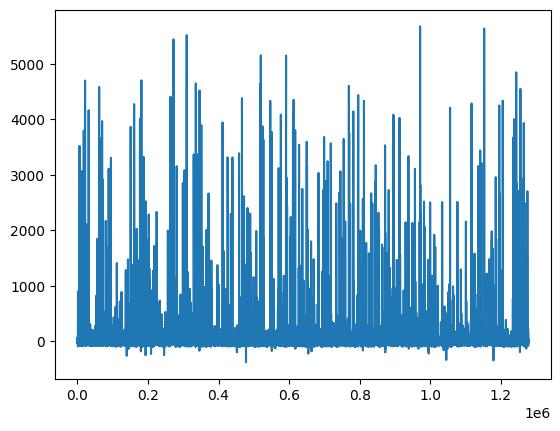

In [52]:
plt.plot(range(Test.shape[1]),Test.loc[0,:])

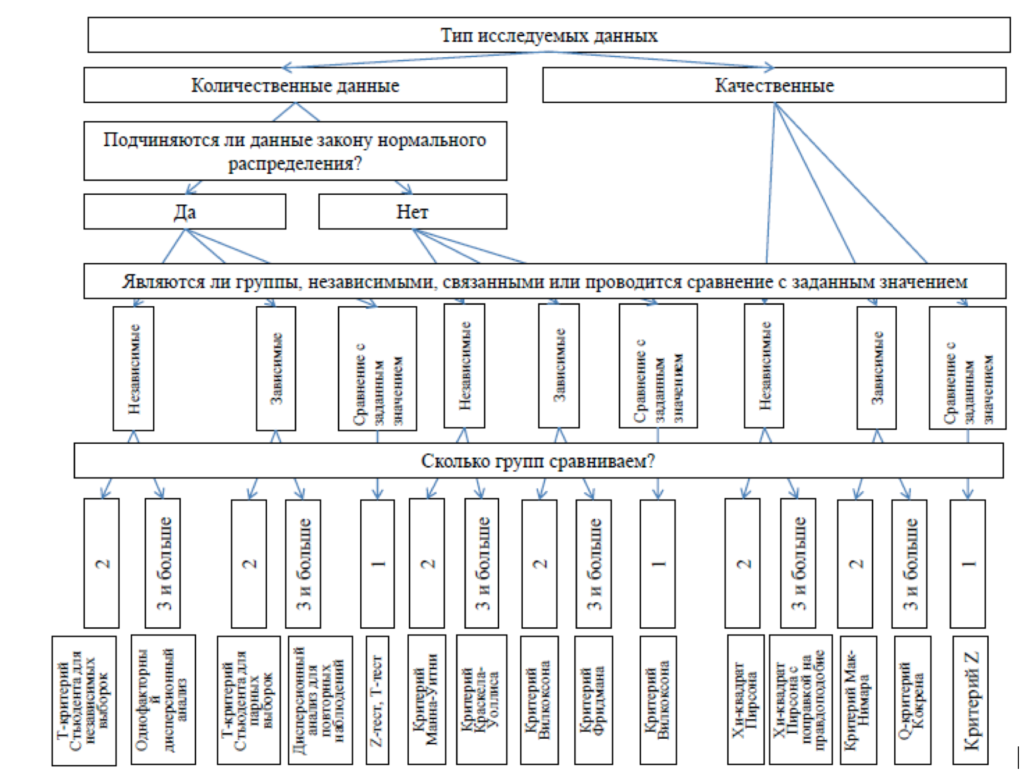

In [14]:
alpha_without_perm_1 = [alpha_3_4_1, alpha_15_16_1, alpha_21_22_1,
                        alpha_27_28_1, alpha_29_30_1, alpha_31_32_1, alpha_33_34_1, alpha_35_36_1, alpha_41_42_1, alpha_43_44_1]
alpha_without_perm_2 = [alpha_3_4_2, alpha_15_16_2, alpha_21_22_2,
                        alpha_27_28_2, alpha_29_30_2, alpha_31_32_2, alpha_33_34_2, alpha_35_36_2, alpha_41_42_2, alpha_43_44_2]
alpha_without_perm_1 = np.array(alpha_without_perm_1)
alpha_without_perm_2 = np.array(alpha_without_perm_2)
alpha_without_perm_1.shape

(10, 15, 15)

In [15]:
alpha_perm_1_time = [alpha_3_4_1_time, alpha_15_16_1_time, alpha_21_22_1_time,
                        alpha_27_28_1_time, alpha_29_30_1_time, alpha_31_32_1_time, alpha_33_34_1_time,
                             alpha_35_36_1_time, alpha_41_42_1_time, alpha_43_44_1_time]
alpha_perm_2_time = [alpha_3_4_2_time, alpha_15_16_2_time, alpha_21_22_2_time,
                        alpha_27_28_2_time, alpha_29_30_2_time, alpha_31_32_2_time, alpha_33_34_2_time,
                             alpha_35_36_2_time, alpha_41_42_2_time, alpha_43_44_2_time]
alpha_perm_1_time = np.array(alpha_perm_1_time)
alpha_perm_2_time = np.array(alpha_perm_2_time)

In [11]:
# perm_alpha_15_16 = []
# num_perm = 10
# for i in range(num_perm):
#     perm_alpha_15_16.append(permutation(df_15_16))

In [16]:
perm_alpha_1 = [permutation(df_3_4)[0], permutation(df_15_16)[0], permutation(df_21_22)[0], 
              permutation(df_27_28)[0], permutation(df_29_30)[0], permutation(df_31_32)[0],
             permutation(df_33_34)[0],permutation(df_35_36)[0],permutation(df_41_42)[0],
             permutation(df_43_44)[0]]
perm_alpha_2 = [permutation(df_3_4)[1], permutation(df_15_16)[1], permutation(df_21_22)[1], 
              permutation(df_27_28)[1], permutation(df_29_30)[1], permutation(df_31_32)[1],
             permutation(df_33_34)[1],permutation(df_35_36)[1],permutation(df_41_42)[1],
             permutation(df_43_44)[1]]
perm_alpha_1 = np.array(perm_alpha_1)
perm_alpha_2 = np.array(perm_alpha_2)

Creating RawArray with float64 data, n_channels=15, n_times=1244927
    Range : 0 ... 1244926 =      0.000 ...  2489.852 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1244927
    Range : 0 ... 1244926 =      0.000 ...  2489.852 secs
Ready.
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 187 events and 4210 original time points ...
0 bad epochs dropped
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 187 events and 4210 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1278070
    Range : 0 ... 1278069 =      0.000 ...  2556.138 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1278070
    Range : 0 ... 1278069 =      0.000 ...  2556.138 secs
Ready.
Not setting metadata
167 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 167 events and 4211 original time points ...
0 bad epochs dropped
Not setting metadata
167 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 167 events and 4211 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1538136
    Range : 0 ... 1538135 =      0.000 ...  3076.270 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1538136
    Range : 0 ... 1538135 =      0.000 ...  3076.270 secs
Ready.
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 238 events and 3289 original time points ...
0 bad epochs dropped
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 238 events and 3289 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1152112
    Range : 0 ... 1152111 =      0.000 ...  2304.222 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1152112
    Range : 0 ... 1152111 =      0.000 ...  2304.222 secs
Ready.
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 209 events and 3287 original time points ...
0 bad epochs dropped
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 209 events and 3287 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1528208
    Range : 0 ... 1528207 =      0.000 ...  3056.414 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1528208
    Range : 0 ... 1528207 =      0.000 ...  3056.414 secs
Ready.
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 4170 original time points ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 4170 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527536
    Range : 0 ... 1527535 =      0.000 ...  3055.070 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527536
    Range : 0 ... 1527535 =      0.000 ...  3055.070 secs
Ready.
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 4174 original time points ...
0 bad epochs dropped
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 4174 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1525461
    Range : 0 ... 1525460 =      0.000 ...  3050.920 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1525461
    Range : 0 ... 1525460 =      0.000 ...  3050.920 secs
Ready.
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 219 events and 3656 original time points ...
0 bad epochs dropped
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 219 events and 3656 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527649
    Range : 0 ... 1527648 =      0.000 ...  3055.296 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527649
    Range : 0 ... 1527648 =      0.000 ...  3055.296 secs
Ready.
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 3655 original time points ...
0 bad epochs dropped
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 3655 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527855
    Range : 0 ... 1527854 =      0.000 ...  3055.708 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527855
    Range : 0 ... 1527854 =      0.000 ...  3055.708 secs
Ready.
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 306 events and 3287 original time points ...
0 bad epochs dropped
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 306 events and 3287 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1528262
    Range : 0 ... 1528261 =      0.000 ...  3056.522 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1528262
    Range : 0 ... 1528261 =      0.000 ...  3056.522 secs
Ready.
Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 3289 original time points ...
0 bad epochs dropped
Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 3289 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1244927
    Range : 0 ... 1244926 =      0.000 ...  2489.852 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1244927
    Range : 0 ... 1244926 =      0.000 ...  2489.852 secs
Ready.
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 187 events and 4210 original time points ...
0 bad epochs dropped
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 187 events and 4210 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1278070
    Range : 0 ... 1278069 =      0.000 ...  2556.138 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1278070
    Range : 0 ... 1278069 =      0.000 ...  2556.138 secs
Ready.
Not setting metadata
167 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 167 events and 4211 original time points ...
0 bad epochs dropped
Not setting metadata
167 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 167 events and 4211 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1538136
    Range : 0 ... 1538135 =      0.000 ...  3076.270 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1538136
    Range : 0 ... 1538135 =      0.000 ...  3076.270 secs
Ready.
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 238 events and 3289 original time points ...
0 bad epochs dropped
Not setting metadata
238 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 238 events and 3289 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1152112
    Range : 0 ... 1152111 =      0.000 ...  2304.222 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1152112
    Range : 0 ... 1152111 =      0.000 ...  2304.222 secs
Ready.
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 209 events and 3287 original time points ...
0 bad epochs dropped
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 209 events and 3287 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1528208
    Range : 0 ... 1528207 =      0.000 ...  3056.414 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1528208
    Range : 0 ... 1528207 =      0.000 ...  3056.414 secs
Ready.
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 4170 original time points ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 4170 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527536
    Range : 0 ... 1527535 =      0.000 ...  3055.070 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527536
    Range : 0 ... 1527535 =      0.000 ...  3055.070 secs
Ready.
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 4174 original time points ...
0 bad epochs dropped
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 4174 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1525461
    Range : 0 ... 1525460 =      0.000 ...  3050.920 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1525461
    Range : 0 ... 1525460 =      0.000 ...  3050.920 secs
Ready.
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 219 events and 3656 original time points ...
0 bad epochs dropped
Not setting metadata
219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 219 events and 3656 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527649
    Range : 0 ... 1527648 =      0.000 ...  3055.296 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527649
    Range : 0 ... 1527648 =      0.000 ...  3055.296 secs
Ready.
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 3655 original time points ...
0 bad epochs dropped
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 3655 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1527855
    Range : 0 ... 1527854 =      0.000 ...  3055.708 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1527855
    Range : 0 ... 1527854 =      0.000 ...  3055.708 secs
Ready.
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 306 events and 3287 original time points ...
0 bad epochs dropped
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 306 events and 3287 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


Creating RawArray with float64 data, n_channels=15, n_times=1528262
    Range : 0 ... 1528261 =      0.000 ...  3056.522 secs
Ready.
Creating RawArray with float64 data, n_channels=15, n_times=1528262
    Range : 0 ... 1528261 =      0.000 ...  3056.522 secs
Ready.
Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 3289 original time points ...
0 bad epochs dropped
Not setting metadata
225 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 225 events and 3289 original time points ...
0 bad epochs dropped


C:\Temp\ipykernel_1456\3940674304.py:18: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_1.set_montage(montage)
C:\Temp\ipykernel_1456\3940674304.py:19: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne_array_2.set_montage(montage)


In [12]:
# perm_alpha_15_16_array_1 = perm_alpha_15_16_array[:, 0]
# perm_alpha_15_16_array_2 = perm_alpha_15_16_array[:, 1]

In [17]:
p_values_welch = np.zeros((15, 15))
p_values_kruskal = np.zeros((15, 15))
p_values_welch_time = np.zeros((15, 15))
p_values_kruskal_time = np.zeros((15, 15))
p_values_wilcoxon = np.zeros((15, 15))
p_values_wilcoxon_time = np.zeros((15, 15))
p_values_mannwhitneyu = np.zeros((15, 15))
p_values_mannwhitneyu_time = np.zeros((15, 15))
p_values_welch_2 = np.zeros((15, 15))
p_values_kruskal_2 = np.zeros((15, 15))
p_values_welch_time_2 = np.zeros((15, 15))
p_values_kruskal_time_2 = np.zeros((15, 15))
p_values_wilcoxon_2 = np.zeros((15, 15))
p_values_wilcoxon_time_2 = np.zeros((15, 15))
p_values_mannwhitneyu_2 = np.zeros((15, 15))
p_values_mannwhitneyu_time_2 = np.zeros((15, 15))

In [18]:
ch_names = ['Fpz','F7','F3','Fz','F4','F8','C3',
            'C4','T5','P3','Pz','P4','T6','O1','O2']

In [19]:
# t_test permutation by epochs
for i in range(15):
    for j in range(15):
        #### alpha_1
        p_values_welch[i,j] = stats.ttest_ind(perm_alpha_1[:,i,j],alpha_without_perm_1[:,i,j],equal_var=False)[1]
        p_values_kruskal[i,j] = stats.kruskal(perm_alpha_1[:,i,j],alpha_without_perm_1[:,i,j])[1]
        p_values_wilcoxon[i,j] = stats.wilcoxon(perm_alpha_1[:,i,j],alpha_without_perm_1[:,i,j])[1]
        p_values_mannwhitneyu[i,j] = stats.mannwhitneyu(perm_alpha_1[:,i,j],alpha_without_perm_1[:,i,j])[1]
        p_values_welch_time[i,j] = stats.ttest_ind(alpha_perm_1_time[:,i,j],alpha_without_perm_1[:,i,j],equal_var=False)[1]
        p_values_kruskal_time[i,j] = stats.kruskal(alpha_perm_1_time[:,i,j],alpha_without_perm_1[:,i,j])[1]
        p_values_wilcoxon_time[i,j] = stats.wilcoxon(alpha_perm_1_time[:,i,j],alpha_without_perm_1[:,i,j])[1]
        p_values_mannwhitneyu_time[i,j] = stats.mannwhitneyu(alpha_perm_1_time[:,i,j],alpha_without_perm_1[:,i,j])[1]
        #### alpha_2
        p_values_welch_2[i,j] = stats.ttest_ind(perm_alpha_2[:,i,j],alpha_without_perm_2[:,i,j],equal_var=False)[1]
        p_values_kruskal_2[i,j] = stats.kruskal(perm_alpha_2[:,i,j],alpha_without_perm_2[:,i,j])[1]
        p_values_wilcoxon_2[i,j] = stats.wilcoxon(perm_alpha_2[:,i,j],alpha_without_perm_2[:,i,j])[1]
        p_values_mannwhitneyu_2[i,j] = stats.mannwhitneyu(perm_alpha_2[:,i,j],alpha_without_perm_2[:,i,j])[1]
        p_values_welch_time_2[i,j] = stats.ttest_ind(alpha_perm_2_time[:,i,j],alpha_without_perm_2[:,i,j],equal_var=False)[1]
        p_values_kruskal_time_2[i,j] = stats.kruskal(alpha_perm_2_time[:,i,j],alpha_without_perm_2[:,i,j])[1]
        p_values_wilcoxon_time_2[i,j] = stats.wilcoxon(alpha_perm_2_time[:,i,j],alpha_without_perm_2[:,i,j])[1]
        p_values_mannwhitneyu_time_2[i,j] = stats.mannwhitneyu(alpha_perm_2_time[:,i,j],alpha_without_perm_2[:,i,j])[1]

# alpha 1

In [30]:
p_values_wilcoxon_df = pd.DataFrame(p_values_wilcoxon)
p_values_wilcoxon_df.columns = ch_names
p_values_wilcoxon_df.index = ch_names
print((p_values_wilcoxon_df<=0.05).sum().sum(),'\n',(p_values_wilcoxon_df<=0.05).sum())
p_values_wilcoxon_df

6 
 Fpz    1
F7     0
F3     1
Fz     0
F4     1
F8     1
C3     1
C4     0
T5     0
P3     0
Pz     0
P4     0
T6     0
O1     1
O2     0
dtype: int64


,Fpz,F7,F3,Fz,F4,F8,C3,C4,T5,P3,Pz,P4,T6,O1,O2
Fpz,0.769531,0.083984,0.845703,0.921875,0.921875,1.000000,0.845703,0.845703,0.492188,0.375000,0.431641,0.322266,0.492188,0.492188,0.375000
F7,0.431641,0.921875,0.921875,0.322266,0.275391,0.492188,0.625000,0.492188,1.000000,0.193359,1.000000,0.275391,0.921875,0.695312,0.921875
F3,0.695312,0.232422,1.000000,0.130859,0.027344,0.431641,0.013672,0.275391,1.000000,0.232422,0.695312,0.275391,0.845703,0.769531,0.695312
Fz,0.845703,0.322266,1.000000,0.275391,0.921875,0.275391,0.232422,0.921875,0.921875,0.083984,0.921875,0.695312,0.695312,0.375000,0.769531
F4,0.275391,0.625000,0.921875,0.556641,0.769531,0.769531,0.921875,0.160156,0.845703,0.193359,0.769531,0.322266,0.625000,0.130859,0.275391
F8,0.695312,0.130859,0.625000,0.921875,0.769531,0.275391,0.160156,0.193359,0.556641,0.275391,0.193359,0.105469,0.695312,0.921875,0.160156
C3,0.048828,0.160156,0.003906,0.375000,0.105469,1.000000,1.000000,1.000000,1.000000,0.556641,1.000000,0.845703,0.556641,0.695312,0.431641
C4,0.160156,0.375000,0.064453,0.625000,0.431641,0.322266,1.000000,0.625000,0.322266,0.695312,0.375000,0.769531,0.845703,0.375000,0.492188
T5,0.232422,0.431641,1.000000,0.845703,0.160156,0.064453,0.322266,0.556641,0.431641,0.845703,0.322266,0.105469,1.000000,0.013672,1.000000
P3,0.695312,0.275391,0.556641,0.769531,0.695312,0.130859,0.431641,1.000000,0.845703,0.695312,0.322266,0.232422,0.769531,0.431641,0.064453


In [31]:
p_values_wilcoxon_time_df = pd.DataFrame(p_values_wilcoxon_time)
p_values_wilcoxon_time_df.columns = ch_names
p_values_wilcoxon_time_df.index = ch_names
print((p_values_wilcoxon_time_df<=0.05).sum().sum(),'\n',(p_values_wilcoxon_time_df<=0.05).sum())
p_values_wilcoxon_time_df

30 
 Fpz    1
F7     0
F3     3
Fz     3
F4     4
F8     4
C3     1
C4     4
T5     1
P3     0
Pz     0
P4     3
T6     1
O1     2
O2     3
dtype: int64


,Fpz,F7,F3,Fz,F4,F8,C3,C4,T5,P3,Pz,P4,T6,O1,O2
Fpz,0.921875,0.769531,0.064453,0.769531,0.105469,0.375000,0.232422,0.492188,0.193359,1.000000,0.556641,0.322266,0.695312,0.625000,1.000000
F7,0.083984,0.431641,0.375000,0.921875,0.769531,0.769531,0.105469,0.695312,0.556641,0.845703,0.921875,0.556641,0.769531,0.625000,0.625000
F3,1.000000,0.492188,0.013672,0.019531,0.048828,0.037109,0.083984,0.037109,0.625000,0.695312,0.921875,0.845703,0.019531,1.000000,0.193359
Fz,0.275391,0.322266,0.695312,0.193359,0.193359,0.232422,0.193359,0.064453,0.845703,0.160156,0.492188,0.322266,0.193359,0.193359,0.921875
F4,0.083984,0.322266,0.105469,0.232422,0.001953,0.083984,0.492188,0.769531,0.845703,0.193359,0.375000,0.556641,0.064453,0.625000,0.845703
F8,0.556641,0.625000,0.375000,0.431641,0.492188,0.027344,0.275391,0.083984,0.232422,0.845703,0.322266,0.160156,0.769531,0.322266,0.160156
C3,0.921875,0.492188,0.695312,0.492188,0.322266,0.083984,0.322266,0.037109,0.193359,0.375000,0.232422,0.375000,0.921875,0.275391,0.009766
C4,0.037109,0.193359,0.492188,0.130859,0.019531,0.003906,0.375000,0.105469,0.556641,0.064453,0.492188,0.083984,0.492188,0.064453,0.005859
T5,0.232422,0.556641,0.027344,0.625000,0.556641,0.193359,1.000000,0.160156,0.492188,0.130859,0.322266,0.005859,0.556641,0.625000,0.083984
P3,0.083984,1.000000,0.037109,0.083984,0.083984,0.003906,0.695312,0.005859,0.232422,0.695312,0.921875,0.769531,0.556641,0.275391,0.921875


In [32]:
p_values_mannwhitneyu_df = pd.DataFrame(p_values_mannwhitneyu)
p_values_mannwhitneyu_df.columns = ch_names
p_values_mannwhitneyu_df.index = ch_names
print((p_values_mannwhitneyu_df<=0.05).sum().sum(),'\n',(p_values_mannwhitneyu_df<=0.05).sum())
p_values_mannwhitneyu_df

5 
 Fpz    0
F7     0
F3     1
Fz     1
F4     1
F8     1
C3     1
C4     0
T5     0
P3     0
Pz     0
P4     0
T6     0
O1     0
O2     0
dtype: int64


,Fpz,F7,F3,Fz,F4,F8,C3,C4,T5,P3,Pz,P4,T6,O1,O2
Fpz,0.733730,0.140465,0.733730,0.623176,0.850107,0.909722,0.791337,0.520523,0.677585,0.472676,0.733730,0.241322,0.241322,0.344704,0.427355
F7,0.140465,1.000000,0.969850,0.307489,0.520523,0.344704,0.623176,0.472676,0.909722,0.212294,0.733730,0.140465,0.677585,0.520523,1.000000
F3,0.969850,0.088973,1.000000,0.045155,0.045155,0.520523,0.011330,0.472676,0.909722,0.307489,0.909722,0.241322,0.623176,0.969850,0.384673
Fz,0.791337,0.427355,0.909722,0.273036,0.472676,0.140465,0.212294,0.969850,0.791337,0.307489,0.384673,0.623176,0.733730,0.427355,0.570750
F4,0.273036,0.850107,0.909722,0.677585,0.969850,0.623176,0.909722,0.121225,0.850107,0.273036,0.791337,0.623176,0.570750,0.121225,0.427355
F8,0.427355,0.161972,0.472676,0.520523,0.909722,0.273036,0.212294,0.273036,0.677585,0.384673,0.344704,0.185877,0.427355,0.791337,0.344704
C3,0.104110,0.140465,0.031209,0.344704,0.104110,0.909722,0.850107,0.791337,0.909722,0.570750,0.733730,0.969850,0.344704,0.344704,0.104110
C4,0.185877,0.520523,0.121225,0.520523,0.273036,0.185877,0.623176,0.623176,0.520523,0.570750,0.121225,0.733730,0.791337,0.427355,0.384673
T5,0.121225,0.241322,0.969850,0.791337,0.273036,0.088973,0.344704,0.677585,0.472676,0.791337,0.307489,0.212294,0.850107,0.053903,0.677585
P3,0.850107,0.520523,0.161972,0.570750,0.570750,0.241322,0.791337,0.909722,0.969850,0.850107,0.909722,0.212294,0.623176,0.733730,0.088973


In [33]:
p_values_mannwhitneyu_df_time = pd.DataFrame(p_values_mannwhitneyu_time)
p_values_mannwhitneyu_df_time.columns = ch_names
p_values_mannwhitneyu_df_time.index = ch_names
print((p_values_mannwhitneyu_df_time<=0.05).sum().sum(),'\n',(p_values_mannwhitneyu_df_time<=0.05).sum())
p_values_mannwhitneyu_df_time

31 
 Fpz    1
F7     0
F3     2
Fz     4
F4     4
F8     6
C3     1
C4     3
T5     1
P3     1
Pz     0
P4     3
T6     1
O1     1
O2     3
dtype: int64


,Fpz,F7,F3,Fz,F4,F8,C3,C4,T5,P3,Pz,P4,T6,O1,O2
Fpz,0.850107,0.623176,0.053903,0.733730,0.088973,0.307489,0.273036,0.909722,0.140465,0.909722,0.623176,0.384673,0.791337,0.677585,0.909722
F7,0.088973,0.307489,0.570750,0.733730,0.791337,0.520523,0.104110,0.520523,0.520523,0.427355,0.969850,0.427355,0.520523,0.344704,0.850107
F3,0.909722,0.570750,0.007285,0.009108,0.075662,0.037635,0.212294,0.088973,0.185877,0.733730,0.791337,0.791337,0.011330,0.850107,0.273036
Fz,0.212294,0.241322,0.520523,0.273036,0.307489,0.185877,0.140465,0.212294,0.520523,0.273036,0.733730,0.307489,0.185877,0.344704,0.850107
F4,0.121225,0.733730,0.104110,0.273036,0.009108,0.009108,0.212294,0.791337,0.733730,0.161972,0.677585,0.791337,0.053903,0.344704,0.909722
F8,0.472676,0.623176,0.273036,0.570750,0.570750,0.017257,0.570750,0.088973,0.212294,0.733730,0.570750,0.064022,0.733730,0.791337,0.384673
C3,0.969850,0.472676,0.733730,0.969850,0.623176,0.037635,0.185877,0.021134,0.045155,0.307489,0.307489,0.520523,0.427355,0.241322,0.021134
C4,0.075662,0.088973,0.791337,0.140465,0.017257,0.025748,0.273036,0.121225,0.344704,0.053903,0.384673,0.045155,0.241322,0.161972,0.003611
T5,0.185877,0.241322,0.088973,0.677585,1.000000,0.045155,0.850107,0.104110,0.384673,0.053903,0.344704,0.017257,0.212294,0.570750,0.088973
P3,0.045155,0.677585,0.045155,0.037635,0.140465,0.104110,0.623176,0.009108,0.344704,0.969850,0.850107,0.909722,0.384673,0.121225,0.909722


In [39]:
# p_values_welch_df = pd.DataFrame(p_values_welch)
# p_values_welch_df.columns = ch_names
# p_values_welch_df.index = ch_names
# print((p_values_welch_df<=0.05).sum().sum(),'\n',(p_values_welch_df<=0.05).sum())
# p_values_welch_df

In [40]:
# p_values_kruskal_df = pd.DataFrame(p_values_kruskal)
# p_values_kruskal_df.columns = ch_names
# p_values_kruskal_df.index = ch_names
# print((p_values_kruskal_df<=0.05).sum().sum(),'\n',(p_values_kruskal_df<=0.05).sum())
# p_values_kruskal_df

In [41]:
# p_values_welch_time_df = pd.DataFrame(p_values_welch_time)
# p_values_welch_time_df.columns = ch_names
# p_values_welch_time_df.index = ch_names
# print((p_values_welch_time_df<=0.05).sum().sum(),'\n',(p_values_welch_time_df<=0.05).sum())
# p_values_welch_time_df

In [52]:
# p_values_kruskal_time_df = pd.DataFrame(p_values_kruskal_time)
# p_values_kruskal_time_df.columns = ch_names
# p_values_kruskal_time_df.index = ch_names
# print((p_values_kruskal_time_df<=0.05).sum().sum(),'\n',(p_values_kruskal_time_df<=0.05).sum())
# p_values_kruskal_time_df

In [29]:
p_values_mannwhitneyu_df_time_2<=0.05

,Fpz,F7,F3,Fz,F4,F8,C3,C4,T5,P3,Pz,P4,T6,O1,O2
Fpz,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
F7,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
F3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
Fz,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False
F4,False,True,False,False,False,True,False,False,False,True,True,False,False,False,False
F8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
C3,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False
C4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
T5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
P3,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [28]:
p_values_mannwhitneyu_df_time<=0.05

,Fpz,F7,F3,Fz,F4,F8,C3,C4,T5,P3,Pz,P4,T6,O1,O2
Fpz,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
F7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
F3,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False
Fz,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
F4,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False
F8,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
C3,False,False,False,False,False,True,False,True,True,False,False,False,False,False,True
C4,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True
T5,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
P3,True,False,True,True,False,False,False,True,False,False,False,False,False,False,False


# alpha 2 

In [34]:
p_values_wilcoxon_df_2 = pd.DataFrame(p_values_wilcoxon_2)
p_values_wilcoxon_df_2.columns = ch_names
p_values_wilcoxon_df_2.index = ch_names
print((p_values_wilcoxon_df_2<=0.05).sum().sum(),'\n',(p_values_wilcoxon_df_2<=0.05).sum())
p_values_wilcoxon_df_2

11 
 Fpz    0
F7     2
F3     2
Fz     0
F4     0
F8     1
C3     0
C4     0
T5     1
P3     0
Pz     1
P4     1
T6     2
O1     0
O2     1
dtype: int64


,Fpz,F7,F3,Fz,F4,F8,C3,C4,T5,P3,Pz,P4,T6,O1,O2
Fpz,0.921875,0.037109,0.019531,0.431641,0.431641,0.083984,0.492188,0.625000,0.009766,0.695312,0.083984,0.027344,0.695312,0.625000,0.005859
F7,0.769531,0.769531,0.375000,1.000000,0.769531,0.695312,0.232422,0.322266,1.000000,0.275391,0.375000,0.695312,0.003906,0.375000,0.160156
F3,0.695312,0.556641,0.232422,0.322266,0.431641,0.160156,0.769531,0.625000,0.492188,0.130859,0.921875,1.000000,0.375000,0.322266,1.000000
Fz,0.492188,0.027344,0.625000,0.769531,0.431641,0.232422,0.695312,0.845703,0.769531,1.000000,0.083984,0.193359,0.193359,0.492188,0.375000
F4,0.193359,0.064453,0.625000,0.375000,0.275391,0.492188,0.105469,0.845703,0.695312,0.431641,0.625000,0.232422,0.193359,0.695312,0.625000
F8,0.769531,0.921875,0.322266,0.431641,1.000000,0.845703,0.625000,0.556641,0.845703,0.625000,0.492188,0.431641,0.027344,0.695312,0.921875
C3,0.275391,0.921875,0.322266,0.130859,0.769531,0.048828,0.492188,0.375000,0.105469,0.375000,0.232422,0.492188,0.556641,0.921875,0.625000
C4,0.695312,0.845703,0.027344,0.064453,0.431641,0.232422,0.193359,0.845703,0.492188,0.322266,0.769531,0.492188,0.921875,0.130859,0.769531
T5,0.556641,0.083984,1.000000,0.556641,1.000000,0.160156,0.845703,1.000000,0.921875,0.921875,0.556641,0.625000,0.322266,1.000000,0.275391
P3,0.921875,0.322266,0.769531,0.625000,0.275391,1.000000,0.921875,1.000000,0.556641,0.492188,0.556641,0.625000,0.625000,0.769531,0.431641


In [35]:
p_values_wilcoxon_df_time_2 = pd.DataFrame(p_values_wilcoxon_time_2)
p_values_wilcoxon_df_time_2.columns = ch_names
p_values_wilcoxon_df_time_2.index = ch_names
print((p_values_wilcoxon_df_time_2<=0.05).sum().sum(),'\n',(p_values_wilcoxon_df_time_2<=0.05).sum())
p_values_wilcoxon_df_time_2

32 
 Fpz    0
F7     6
F3     2
Fz     0
F4     1
F8     5
C3     0
C4     4
T5     4
P3     2
Pz     1
P4     4
T6     1
O1     0
O2     2
dtype: int64


,Fpz,F7,F3,Fz,F4,F8,C3,C4,T5,P3,Pz,P4,T6,O1,O2
Fpz,0.232422,0.001953,0.431641,0.130859,0.193359,0.322266,0.130859,0.492188,0.037109,0.083984,0.921875,0.921875,0.695312,0.492188,0.556641
F7,0.695312,0.005859,0.492188,0.845703,0.037109,0.013672,0.556641,0.275391,0.275391,0.695312,0.695312,0.845703,0.556641,0.695312,0.845703
F3,0.625000,0.492188,0.375000,0.921875,0.845703,0.037109,0.556641,0.769531,0.625000,0.105469,0.921875,0.375000,0.921875,0.232422,0.431641
Fz,0.375000,0.083984,0.769531,0.492188,0.845703,0.013672,0.845703,0.431641,0.001953,0.160156,0.921875,0.037109,0.322266,0.083984,0.064453
F4,0.845703,0.009766,0.160156,0.375000,0.695312,0.037109,0.193359,0.921875,0.160156,0.019531,0.064453,0.492188,0.160156,0.193359,0.431641
F8,0.193359,0.105469,0.921875,0.160156,0.556641,0.431641,0.431641,0.275391,0.322266,0.275391,0.845703,1.000000,0.556641,0.625000,0.001953
C3,0.083984,0.064453,0.130859,0.193359,0.322266,0.003906,0.492188,0.027344,0.769531,0.431641,0.322266,0.027344,0.105469,0.160156,0.769531
C4,0.921875,0.048828,0.845703,0.322266,0.322266,0.556641,0.492188,0.769531,0.275391,0.921875,1.000000,0.275391,0.160156,0.769531,0.695312
T5,0.921875,1.000000,1.000000,0.625000,0.431641,0.375000,0.625000,0.105469,0.160156,0.232422,0.232422,0.027344,0.160156,0.375000,0.019531
P3,0.556641,0.275391,0.009766,1.000000,0.193359,0.769531,0.193359,0.625000,0.193359,0.130859,0.375000,0.556641,0.130859,0.232422,0.431641


In [36]:
p_values_mannwhitneyu_df_2 = pd.DataFrame(p_values_mannwhitneyu_2)
p_values_mannwhitneyu_df_2.columns = ch_names
p_values_mannwhitneyu_df_2.index = ch_names
print((p_values_mannwhitneyu_df_2<=0.05).sum().sum(),'\n',(p_values_mannwhitneyu_df_2<=0.05).sum())
p_values_mannwhitneyu_df_2

11 
 Fpz    0
F7     3
F3     0
Fz     1
F4     0
F8     1
C3     0
C4     1
T5     1
P3     0
Pz     1
P4     0
T6     2
O1     0
O2     1
dtype: int64


,Fpz,F7,F3,Fz,F4,F8,C3,C4,T5,P3,Pz,P4,T6,O1,O2
Fpz,0.909722,0.021134,0.121225,0.344704,0.307489,0.161972,0.570750,0.344704,0.037635,0.623176,0.025748,0.053903,0.850107,0.307489,0.014019
F7,0.850107,0.909722,0.344704,0.850107,0.909722,0.733730,0.273036,0.472676,0.570750,0.212294,0.241322,0.677585,0.000769,0.570750,0.520523
F3,0.850107,0.623176,0.161972,0.273036,0.384673,0.140465,0.733730,0.472676,0.472676,0.241322,0.850107,0.969850,0.161972,0.307489,0.623176
Fz,0.520523,0.031209,0.241322,0.969850,0.384673,0.384673,0.344704,0.570750,0.850107,0.850107,0.075662,0.570750,0.212294,0.570750,0.384673
F4,0.241322,0.037635,0.570750,0.384673,0.344704,0.520523,0.121225,0.623176,0.909722,0.273036,0.677585,0.104110,0.037635,0.307489,0.850107
F8,0.570750,0.850107,0.212294,0.427355,1.000000,0.850107,0.427355,0.520523,0.344704,0.384673,0.733730,0.520523,0.140465,1.000000,0.733730
C3,0.570750,0.791337,0.427355,0.025748,0.969850,0.037635,0.427355,0.212294,0.075662,0.427355,0.241322,0.307489,0.384673,0.909722,0.791337
C4,0.909722,0.850107,0.053903,0.185877,0.623176,0.241322,0.212294,0.791337,0.520523,0.427355,0.677585,0.733730,0.969850,0.307489,0.677585
T5,0.623176,0.075662,0.909722,0.273036,0.791337,0.241322,0.909722,0.969850,0.850107,0.850107,0.570750,0.909722,0.384673,0.623176,0.273036
P3,1.000000,0.520523,0.623176,0.969850,0.520523,0.909722,0.969850,0.969850,0.791337,0.623176,0.427355,0.677585,0.677585,0.677585,0.307489


In [37]:
p_values_mannwhitneyu_df_time_2 = pd.DataFrame(p_values_mannwhitneyu_time_2)
p_values_mannwhitneyu_df_time_2.columns = ch_names
p_values_mannwhitneyu_df_time_2.index = ch_names
print((p_values_mannwhitneyu_df_time_2<=0.05).sum().sum(),'\n',(p_values_mannwhitneyu_df_time_2<=0.05).sum())
p_values_mannwhitneyu_df_time_2

28 
 Fpz    1
F7     5
F3     3
Fz     0
F4     0
F8     4
C3     0
C4     2
T5     2
P3     2
Pz     2
P4     3
T6     1
O1     1
O2     2
dtype: int64


,Fpz,F7,F3,Fz,F4,F8,C3,C4,T5,P3,Pz,P4,T6,O1,O2
Fpz,0.161972,0.000183,0.969850,0.427355,0.185877,0.161972,0.075662,0.850107,0.037635,0.064022,0.969850,1.000000,0.427355,0.344704,0.677585
F7,0.850107,0.031209,0.677585,0.733730,0.104110,0.045155,0.520523,0.570750,0.273036,0.909722,0.969850,0.969850,0.623176,0.623176,0.307489
F3,0.520523,0.307489,0.520523,0.909722,0.384673,0.021134,0.909722,0.677585,0.472676,0.241322,0.791337,0.570750,0.850107,0.427355,0.384673
Fz,0.307489,0.031209,0.623176,0.791337,0.733730,0.075662,0.733730,0.384673,0.001315,0.140465,0.791337,0.021134,0.570750,0.053903,0.075662
F4,0.850107,0.003611,0.307489,0.241322,0.791337,0.031209,0.140465,0.969850,0.307489,0.021134,0.037635,0.909722,0.104110,0.185877,0.344704
F8,0.273036,0.140465,0.909722,0.344704,0.307489,0.344704,0.427355,0.677585,0.520523,0.241322,0.850107,0.969850,0.733730,0.969850,0.037635
C3,0.161972,0.064022,0.121225,0.212294,0.273036,0.001706,0.212294,0.212294,0.791337,0.791337,0.384673,0.037635,0.045155,0.161972,0.791337
C4,0.850107,0.140465,0.969850,0.344704,0.850107,0.791337,0.384673,0.677585,0.241322,0.850107,0.909722,0.241322,0.121225,1.000000,0.344704
T5,0.791337,0.909722,0.791337,0.909722,0.472676,0.212294,0.733730,0.241322,0.212294,0.185877,0.140465,0.064022,0.088973,0.185877,0.037635
P3,0.623176,0.075662,0.003611,0.791337,0.212294,0.570750,0.307489,0.677585,0.344704,0.121225,0.570750,0.570750,0.121225,0.045155,0.570750


C:\Users\Nikita\AppData\Local\Programs\Python\Python311\Lib\site-packages\hypyp\viz.py:215: RuntimeWarning: invalid value encountered in scalar divide
  weight = 0.2 +1.6*((C[e1, e2]-threshold)/(np.nanmax(C[:]-threshold)))


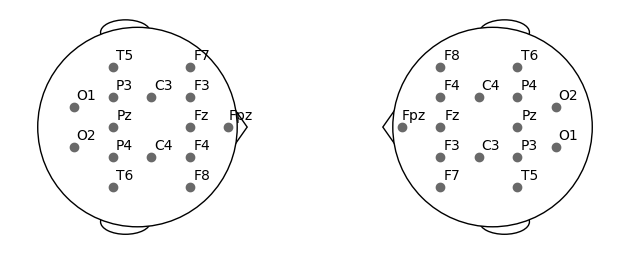

<Axes: >

In [151]:
viz.viz_2D_topomap_inter(epoch_1, epoch_2, p_values_kruskal_time, threshold=1, steps=30, lab=True)

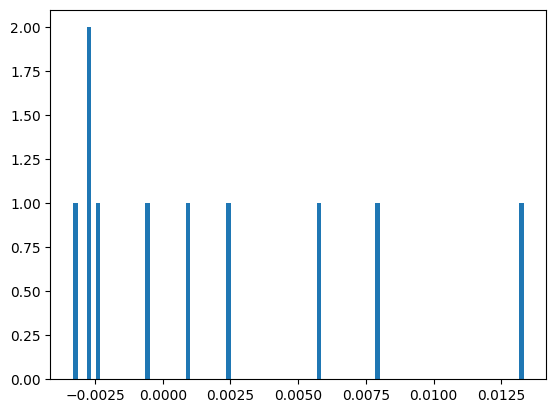

In [56]:
plt.hist(dist_perm_1_sensor,bins = int(100))
plt.show()

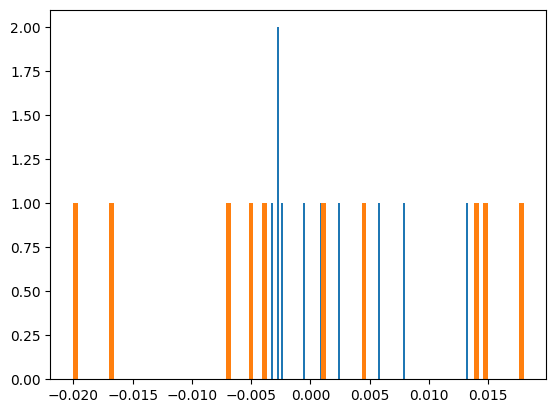

In [57]:
plt.hist(dist_perm_1_sensor,bins = int(100))
plt.hist(dist_no_perm_1_sensor,bins = int(100))
plt.show()

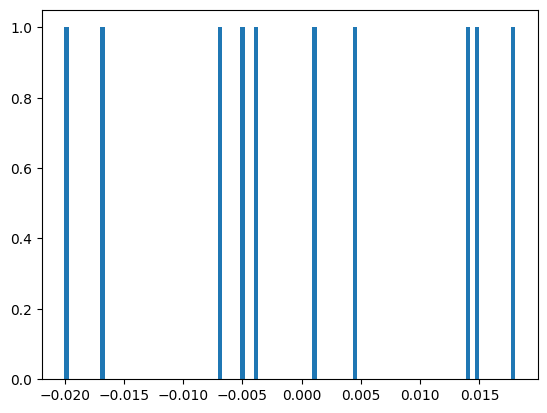

In [54]:
plt.hist(dist_no_perm_1_sensor,bins = int(100))
plt.show()

In [ ]:
# for i in range(len(events_mne)):
#     events_mne[i][0]*=250
# events_mne

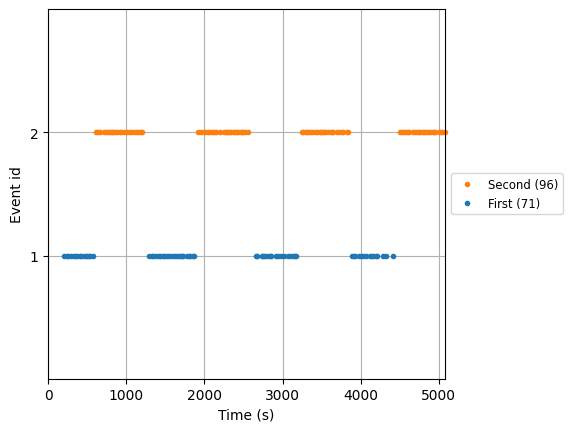

In [33]:
fig = mne.viz.plot_events(events_mne, sfreq=500, event_id=event_id)
fig.subplots_adjust(right=0.7)  # make room for legend

In [505]:
# events['Latency'] = events['Latency'].apply(lambda x: int(x))
# events['Latency'].duplicated().sum()

C:\Temp\ipykernel_6340\212776115.py:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  montage.plot()


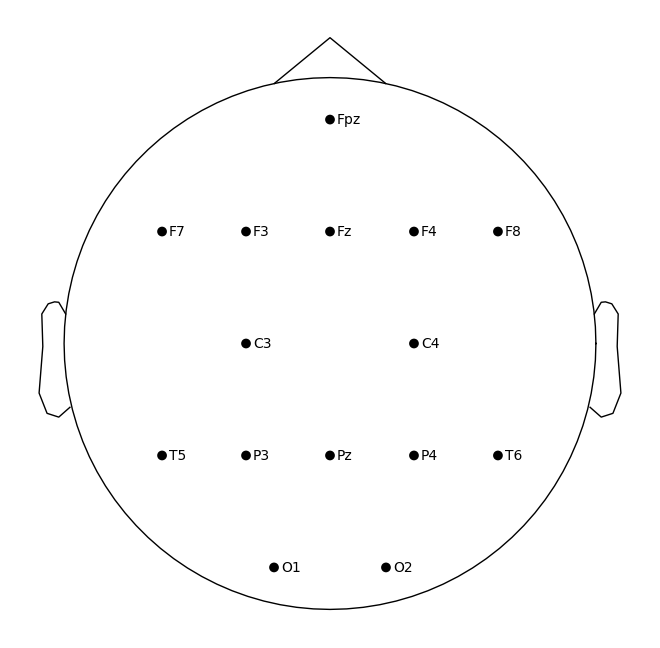

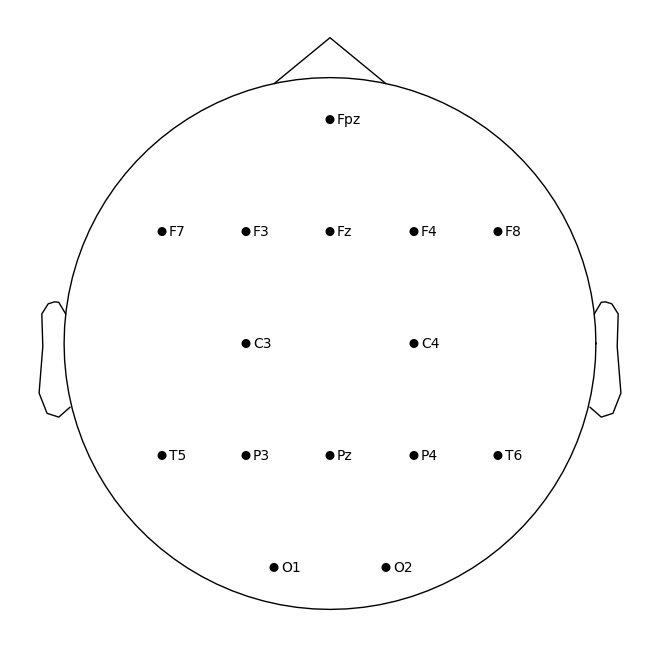

In [34]:
#montage = mne.channels.make_standard_montage('biosemi16')
locations = {'Fpz':[0,0.08,0],'F7':[-0.06,0.04,0],'F3':[-0.03,0.04,0],'Fz':[0,0.04,0],'F4':[0.03,0.04,0],
             'F8':[0.06,0.04,0],'C3':[-0.03,0,0],'C4':[0.03,0,0],'T5':[-0.06,-0.04,0],'P3':[-0.03,-0.04,0],
            'Pz':[0,-0.04,0],'P4':[0.03,-0.04,0],'T6':[0.06,-0.04,0],'O1':[-0.02,-0.08,0],'O2':[0.02,-0.08,0]}
montage = mne.channels.make_dig_montage(locations)
montage.plot()

In [43]:
# without ICA

no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=True
)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/15 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/86 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/86 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/86 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/86 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=1
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/15 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/15 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/86 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/86 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/86 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/86 [00:00<?,       ?it/s]

C:\Users\Nikita\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\bem.py:1129: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\Nikita\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Nikita\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nikita\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=1
Dropped 21 epochs: 0, 7, 15, 18, 30, 33, 43, 49, 51, 54, 58, 65, 67, 69, 70, 79, 80, 81, 82, 83, 84


  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 21 epochs: 0, 7, 15, 18, 30, 33, 43, 49, 51, 54, 58, 65, 67, 69, 70, 79, 80, 81, 82, 83, 84


  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
24.418604651162788 percent of bad epochs
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 600x600 with 4 Axes>

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 600x600 with 4 Axes>

<Figure size 640x480 with 0 Axes>

In [44]:
no_ICA_preproc_S1 = no_ICA_cleaned_epochs_AR[0]
no_ICA_preproc_S2 = no_ICA_cleaned_epochs_AR[1]

In [45]:
no_ICA_preproc_S1

Number of events,65
Events,First: 31Second: 34
Time range,-0.200 – 0.500 s
Baseline,-0.200 – 0.000 s


In [24]:
# preproc_S1

In [46]:
from hypyp import analyses
from scipy.stats import circmean

In [29]:
# psd1 = analyses.pow(preproc_S1, fmin=7.5, fmax=11,
#                     n_fft=1000, n_per_seg=1000, epochs_average=True)
# psd2 = analyses.pow(preproc_S2, fmin=7.5, fmax=11,
#                     n_fft=1000, n_per_seg=1000, epochs_average=True)
# data_psd = np.array([psd1.psd, psd2.psd])

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


In [31]:
# psd_test = analyses.pow(preproc_S2, fmin=7.5, fmax=11,
#                     n_fft=1000, n_per_seg=1000, epochs_average=False)

Effective window size : 2.000 (s)


In [26]:
# psd2.psd

In [47]:
no_ICA_psd1 = analyses.pow(no_ICA_preproc_S1, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
no_ICA_psd2 = analyses.pow(no_ICA_preproc_S2, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
no_ICA_data_psd = np.array([no_ICA_psd1.psd, no_ICA_psd2.psd])

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


In [37]:
# data_inter = np.array([preproc_S1, preproc_S2])
# data_inter_1 = np.array([preproc_S1['First'], preproc_S2['First']])
# data_inter_2 = np.array([preproc_S1['Second'], preproc_S2['Second']])

In [48]:
data_inter_no_ICA_1 = np.array([no_ICA_preproc_S1['First'], no_ICA_preproc_S2['First']])
data_inter_no_ICA_2 = np.array([no_ICA_preproc_S1['Second'], no_ICA_preproc_S2['Second']])

In [49]:
no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])

In [50]:
full_freq = { 'full_frq': [1, 48]}
sampling_rate= 500

In [51]:
from scipy import stats

In [52]:
freq_bands = {'alpha':[7.5,11.5],'beta':[12,20]}
# complex_signal = analyses.compute_freq_bands(data_inter_1,sampling_rate, freq_bands=freq_bands)
# without ICA
no_ICA_complex_signal_1 = analyses.compute_freq_bands(data_inter_no_ICA_1, sampling_rate, freq_bands)
no_ICA_complex_signal_2 = analyses.compute_freq_bands(data_inter_no_ICA_2, sampling_rate, freq_bands)

C:\Users\Nikita\AppData\Local\Programs\Python\Python311\Lib\site-packages\hypyp\analyses.py:695: RuntimeWarning: filter_length (825) is longer than the signal (351), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
C:\Users\Nikita\AppData\Local\Programs\Python\Python311\Lib\site-packages\hypyp\analyses.py:695: RuntimeWarning: filter_length (825) is longer than the signal (351), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
C:\Users\Nikita\AppData\Local\Programs\Python\Python311\Lib\site-packages\hypyp\analyses.py:695: RuntimeWarning: filter_length (551) is longer than the signal (351), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
C:\Users\Nikita\AppData\Local\Programs\Python\Python311\Lib\site-packages\hypyp\analyses.py:695: 

In [53]:
no_ICA_complex_signal_1.shape

(2, 31, 15, 2, 351)

In [54]:
#  n_epoch, n_ch, n_freq, n_samp = no_ICA_complex_signal_1.shape[1], no_ICA_complex_signal_1.shape[2], \
#                                     no_ICA_complex_signal_1.shape[3], no_ICA_complex_signal_1.shape[4]
# transpose_axes = (0, 1, 3, 2)
#     # calculate all epochs at once, the only downside is that the disk may not have enough space
# complex_signal_1 = no_ICA_complex_signal_1.transpose((1, 3, 0, 2, 4)).reshape(n_epoch, n_freq, 2 * n_ch, n_samp)
# transpose_axes_1 = (0, 1, 3, 2)
# angle = np.angle(complex_signal_1)
# mu_angle = circmean(angle, axis=3).reshape(n_epoch, n_freq, 2 * n_ch, 1)
# angle = np.sin(angle - mu_angle)

# # formula = 'nilm,nimk->nilk'
# # con = np.abs(np.einsum(formula, angle, angle.transpose(transpose_axes)) /
# #              np.sqrt(np.einsum('nil,nik->nilk', np.sum(angle ** 2, axis=3), 
# #                                np.sum(angle ** 2, axis=3))))
# # con = con.swapaxes(0, 1)

In [78]:
angle.shape

(31, 2, 30, 351)

In [79]:
np.sum(angle ** 2, axis=3)

array([[[172.11851949, 173.448771  , 177.92125443, ..., 167.4206246 ,
         166.82067698, 171.89171811],
        [175.84983428, 173.53072762, 170.88225228, ..., 186.2681352 ,
         173.86396411, 177.14290128]],

       [[175.98137763, 178.15174912, 168.48844329, ..., 169.06292722,
         175.21086628, 179.01533023],
        [165.29751878, 174.25693919, 169.51773103, ..., 170.29408661,
         177.62836901, 169.05695691]],

       [[173.47922318, 171.6150834 , 176.43418747, ..., 167.94771336,
         173.85827019, 170.77063955],
        [171.9608955 , 176.29658072, 183.81579721, ..., 167.75446343,
         175.22704466, 174.58362444]],

       ...,

       [[168.4297069 , 171.15726601, 171.10793974, ..., 175.02551242,
         172.26972762, 175.54716817],
        [173.50833742, 174.42036365, 177.20489124, ..., 172.36468269,
         175.77470534, 173.21501045]],

       [[176.3378185 , 172.76715011, 175.58238844, ..., 167.17845986,
         175.02400427, 174.54048085],
       

In [72]:
np.einsum(formula, angle, angle.transpose(transpose_axes)).shape

(31, 2, 30, 30)

In [56]:
complex_signal_1.shape

(31, 2, 30, 351)

In [70]:
result_1 = analyses.compute_sync(no_ICA_complex_signal_1, mode='ccorr')
result_2 = analyses.compute_sync(no_ICA_complex_signal_2, mode='ccorr')

In [71]:
n_ch = len(epoch_1.info['ch_names'])
df_res_1 = pd.DataFrame(data=result_1[0][0:n_ch, n_ch:2*n_ch])
df_res_2 = pd.DataFrame(data=result_2[0][0:n_ch, n_ch:2*n_ch])

In [52]:
# psd1_mean = np.mean(psd1.psd, axis=1)
# psd2_mean = np.mean(psd2.psd, axis=1)
# X = np.array([psd1_mean, psd2_mean])
# T_obs, p_values, H0 = mne.stats.permutation_t_test(X=X, n_permutations=2,
#                                                    tail=0, n_jobs=1)
# psd1_mean

In [639]:
# df_res

In [640]:
# df_res_2

In [555]:
#  n_epoch, n_ch, n_freq, n_samp = complex_signal.shape[0], complex_signal.shape[1], \
#                                     complex_signal.shape[2], complex_signal.shape[3]
# complex_signal = complex_signal.transpose((1, 3, 0, 2, 4)).reshape(n_epoch, n_freq, 2 * n_ch, n_samp)
# transpose_axes = (0, 1, 3, 2)

In [69]:
result_intra = []

In [36]:
from scipy.stats import circmean

In [37]:
n_ch = len(epoch_1.info['ch_names'])
alpha_1, betta_1 = result_1[:, 0:n_ch, n_ch:2*n_ch]
alpha_2, betta_2 = result_2[:, 0:n_ch, n_ch:2*n_ch]

In [38]:
C_alpha_1 = (alpha_1 - np.mean(alpha_1[:])) / np.std(alpha_1[:])
C_betta_1 = (betta_1 - np.mean(betta_1[:])) / np.std(betta_1[:])
C_alpha_2 = (alpha_2 - np.mean(alpha_2[:])) / np.std(alpha_2[:])
C_betta_2 = (betta_2 - np.mean(betta_2[:])) / np.std(betta_2[:])

In [39]:
# alpha_1_test_1 = np.concatenate([np.diagonal(alpha_1[::-1,:], k)[::(2*(k % 2)-1)] for k in range(1-alpha_1.shape[0], alpha_1.shape[0])])
# alpha_2_test_2= np.concatenate([np.diagonal(alpha_2[::-1,:], k)[::(2*(k % 2)-1)] for k in range(1-alpha_2.shape[0], alpha_2.shape[0])])
# stats.ttest_ind(alpha_1_test_1, alpha_2_test_2)

Ttest_indResult(statistic=0.24872873208248128, pvalue=0.8036846042085726)

# Graphs

In [82]:
# for i in [0, 1]:
#     alpha_low, alpha_high = result[:, (
#         i * n_ch):((i + 1) * n_ch), (i * n_ch): ((i + 1) * n_ch)]
#     # choosing Alpha_Low for futher analyses for example
#     values_intra = alpha_low
#     values_intra -= np.diag(np.diag(values_intra))
#     # computing Cohens'D for further analyses for example
#     C_intra = (values_intra -
#                np.mean(values_intra[:])) / np.std(values_intra[:])
#     # can also sample CSD values directly for statistical analyses
#     result_intra.append(C_intra)

In [81]:
# PDC = analyses.compute_conn_mvar(no_ICA_complex_signal, 
#                                  mvar_params={"mvar_order": 2, "fitting_method":"default", "delta": 0},
#                                  ica_params={"method": "infomax_extended", "random_state": None},
#                                  measure_params={"name": "pdc", "n_fft": 512}
#                                  )

In [80]:
# no_ICA_result_inter = []
# for i in [0, 1]:
#     PDC_q = PDC.squeeze()
#     if i == 0 :
#         mvar_spectrum =  PDC_q[n_ch:n_ch*2, 0:n_ch, :]
#     else:
#         mvar_spectrum =  PDC_q[0:n_ch, n_ch:n_ch*2, :]   
#     PDC_fmax = np.zeros((n_ch, n_ch), dtype=PDC.dtype)
#     for j in range(0, n_ch):
#         for k in range(0, n_ch):
#             PDC_fmax[j, k] = np.amax(mvar_spectrum[j,k,:])
#     mvar_values_inter = PDC_fmax
#     mvar_values_inter -= np.diag(np.diag(mvar_values_inter))
#     # computing Cohens'D for further analyses for example
#     mvar_C_inter = (mvar_values_inter -
#                np.mean(mvar_values_inter[:])) / np.std(mvar_values_inter[:])
#     # can also sample CSD values directly for statistical analyses
#     no_ICA_result_inter.append(mvar_C_inter)

In [79]:
# no_ICA_result_intra = []
# for i in [0, 1]:
#     PDC = PDC.squeeze()
#     mvar_spectrum =  PDC[i*n_ch:n_ch*(i+1), i*n_ch:n_ch*(i+1), :]
#     # choosing the max values for futher analyses for example
#     PDC_fmax = np.zeros((n_ch, n_ch), dtype=PDC.dtype)
#     for j in range(0, n_ch):
#         for k in range(0, n_ch):
#             PDC_fmax[j, k] = np.amax(mvar_spectrum[j, k, :])
#     mvar_values_intra = PDC_fmax
#     mvar_values_intra -= np.diag(np.diag(mvar_values_intra))
#     # computing Cohens'D for further analyses for example
#     mvar_C_intra = (mvar_values_intra -
#                np.mean(mvar_values_intra[:])) / np.std(mvar_values_intra[:])
#     # can also sample CSD values directly for statistical analyses
#     no_ICA_result_intra.append(mvar_C_intra)

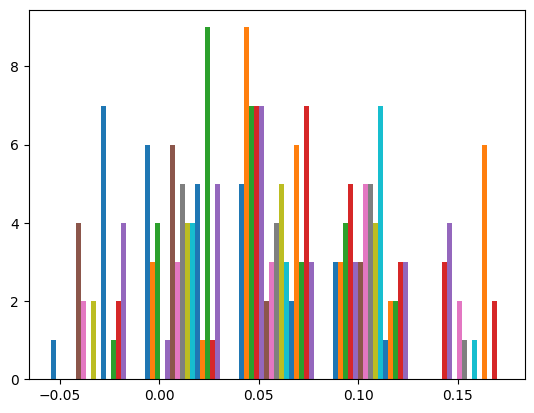

In [73]:
plt.hist(alpha_1,bins = int(5))
plt.show()

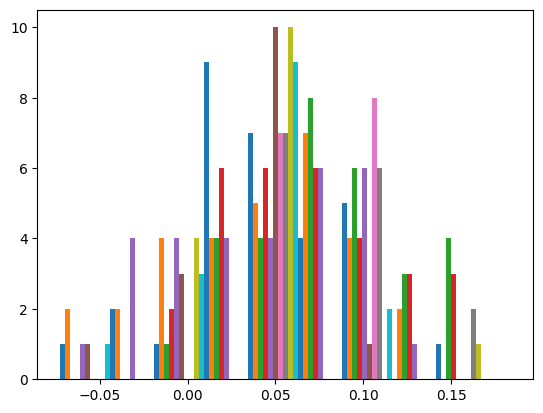

In [74]:
plt.hist(alpha_2,bins = int(5))
plt.show()

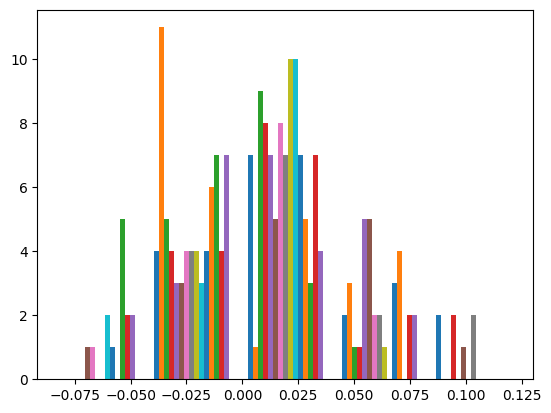

In [75]:
plt.hist(betta_1,bins = int(5))
plt.show()

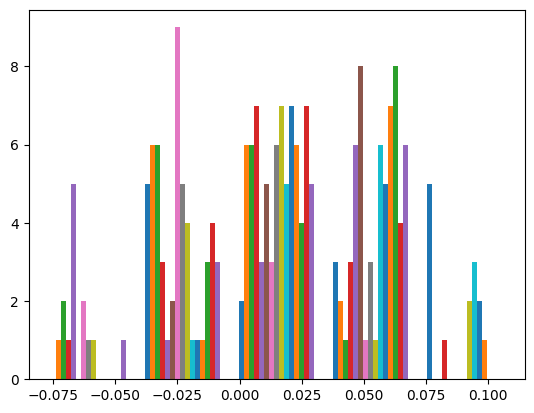

In [76]:
plt.hist(betta_2,bins = int(5))
plt.show()

# Stats

In [61]:
from hypyp import stats
import scipy

In [90]:
result_intra = []
for i in [0, 1]:
    alpha_intra, beta_intra = result_1[:, i:i+n_ch, i:i+n_ch]
    values_intra = alpha_intra
    values_intra -= np.diag(np.diag(values_intra))
    C_intra = (values_intra - np.mean(values_intra[:])) / np.std(values_intra[:]) 
result_intra.append(C_intra) 

In [108]:
alpha_1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)
X = np.array([psd1_mean, psd2_mean])
T_obs, p_values, H0 = mne.stats.permutation_t_test(X=X, n_permutations=5000,
                                                   tail=0, n_jobs=1)
T_obs, p_values, H0 = mne.stats.permutation_t_test(alpha, n_permutations=100,
                                                       tail=0, n_jobs=1)
H0

Permuting 99 times...


array([0.86508417, 0.89776977, 0.968682  , 1.02530244, 1.0850086 ,
       1.10252395, 1.15132209, 1.15274496, 1.15541004, 1.1567942 ,
       1.17399178, 1.19651056, 1.20081857, 1.21524202, 1.22331891,
       1.23345183, 1.24124914, 1.24784605, 1.25746223, 1.26132401,
       1.26280024, 1.28858299, 1.34392829, 1.38629881, 1.4063147 ,
       1.41359822, 1.4364872 , 1.448122  , 1.45060889, 1.45145038,
       1.45151598, 1.45282711, 1.46072295, 1.46374084, 1.50726602,
       1.52046314, 1.55369396, 1.57810045, 1.58597595, 1.62791802,
       1.63421414, 1.63593258, 1.70917521, 1.71743282, 1.78727496,
       1.80336057, 1.80373928, 1.80731435, 1.84206007, 1.85397655,
       1.85856342, 1.87031004, 1.88622178, 1.90162412, 1.91808387,
       1.9658418 , 1.97757637, 1.98997353, 2.00400882, 2.02689382,
       2.03948262, 2.08784797, 2.15691368, 2.17540691, 2.1769498 ,
       2.22813594, 2.25606217, 2.27171745, 2.30144204, 2.33739157,
       2.3412872 , 2.3444284 , 2.37870024, 2.44457431, 2.45722

In [548]:
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)
X = np.array([psd1_mean, psd2_mean])
T_obs, p_values, H0 = mne.stats.permutation_t_test(X=X, n_permutations=5000,
                                                   tail=0, n_jobs=1)

Permuting 1 times (exact test)...


In [549]:
p_values

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5])

In [96]:
statsCondTuple = stats.statsCond(data=data_psd,
                                 epochs=preproc_S1,
                                 n_permutations=5000,
                                 alpha=0.05)

AssertionError: PSD does not have the appropriate shape!

In [551]:
statsCondTuple

statsCond(T_obs=array([1.49072572, 1.71558992, 1.31336272, 1.58841457, 1.81721892,
       4.18282361, 1.37976342, 1.21266367, 1.27729121, 1.20430675,
       1.22723061, 1.18338921, 1.29003983, 1.36422528, 1.43869799]), p_values=array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5]), H0=array([0.84503052, 4.18282361]), adj_p=(array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False]), array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5])), T_obs_plot=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [552]:
con_matrixTuple = stats.con_matrix(preproc_S1, freqs_mean=psd1.freq_list)
ch_con_freq = con_matrixTuple.ch_con_freq

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 15


In [553]:
data_group = [np.array([psd1.psd, psd1.psd, psd1.psd]), np.array([psd2.psd, psd2.psd, psd2.psd])]

statscondCluster = stats.statscondCluster(data=data_group,
                                          freqs_mean=psd1.freq_list,
                                          ch_con_freq=scipy.sparse.bsr_matrix(ch_con_freq),
                                          tail=1,
                                          n_permutations=5000,
                                          alpha=0.05)

Using a threshold of 7.708647
stat_fun(H1): min=-13647213632183480.000000 max=inf
Running initial clustering …
Found 1 cluster


C:\Users\NIKITA\PycharmProjects\pythonProject1\venv\lib\site-packages\mne\stats\parametric.py:170: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

In [459]:
data = [np.array([values, values]), np.array([result_intra[0], result_intra[0]])]

statscondCluster = stats.statscondCluster(data=data,
                                          freqs_mean=np.arange(7.5, 11),
                                          ch_con_freq=None,
                                          tail=0,
                                          n_permutations=5000,
                                          alpha=0.05)

Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering …
Found 1 cluster


C:\Users\NIKITA\PycharmProjects\pythonProject1\venv\lib\site-packages\hypyp\stats.py:337: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(data,


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

In [460]:
statscondCluster.cluster_p_values

array([0.3292])

In [425]:
from hypyp import viz

In [426]:
viz.plot_sensors_2d_intra(preproc_S1,preproc_S2)

In [427]:
statsCondTuple.H0

array([0.78358094, 8.34316858])

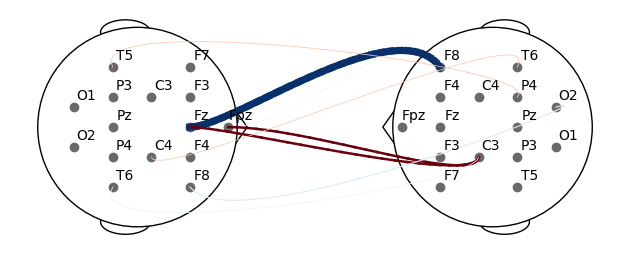

<Axes: >

In [435]:
viz.viz_2D_topomap_inter(epoch_1, epoch_2, C, threshold=2, steps=30, lab=True)

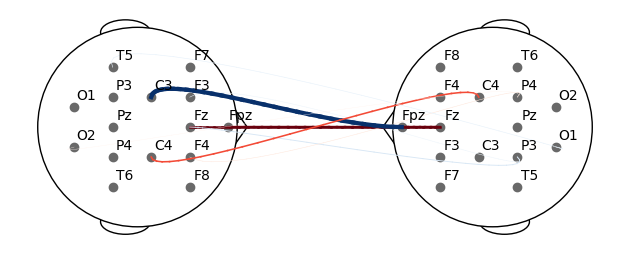

<Axes: >

In [430]:
from hypyp import viz
viz.viz_2D_topomap_inter(epoch_1, epoch_2, C_2, threshold=2, steps=30, lab=True)

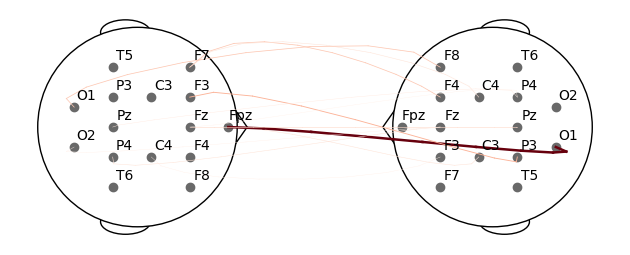

<Axes: >

In [431]:
# Inter-brain VAR-based connectivity (information flow from participant 1 to participant 2)
viz.viz_2D_topomap_inter(epoch_1, epoch_2, no_ICA_result_inter[0], threshold='auto', steps=10, lab=True)

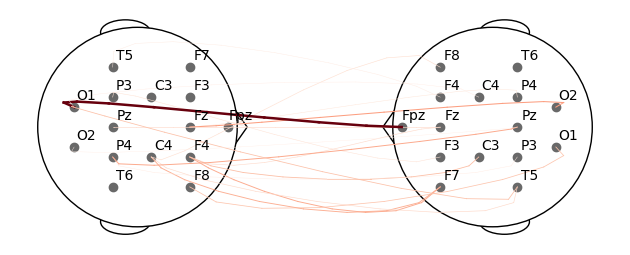

<Axes: >

In [432]:
#Inter-brain VAR-based connectivity (information flow from participant 2 to participant 1)
viz.viz_2D_topomap_inter(epoch_1, epoch_2, no_ICA_result_inter[1], threshold='auto', steps=10, lab=True)

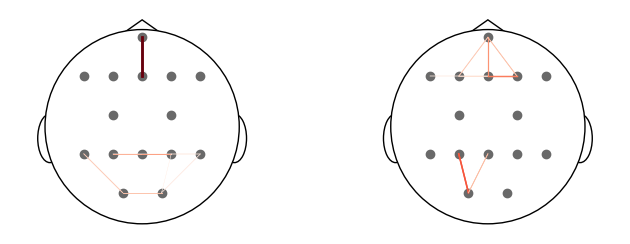

<Axes: >

In [433]:
viz.viz_2D_topomap_intra(epoch_1, epoch_2,
                         C1= result_intra[0],
                         C2= result_intra[1],
                         threshold='auto',
                         steps=2,
                         lab=False)

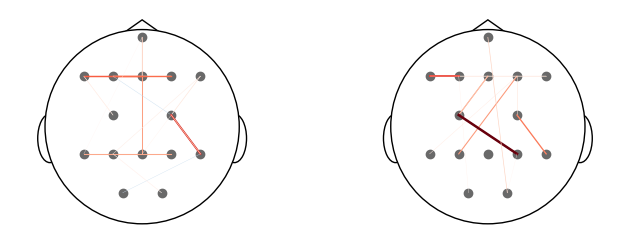

<Axes: >

In [434]:
viz.viz_2D_topomap_intra(epoch_1, epoch_2,
                         C1= no_ICA_result_intra[0],
                         C2= no_ICA_result_intra[1],
                         threshold='auto',
                         steps=2,
                         lab=False)